<a href="https://colab.research.google.com/github/dtabuena/Patch_Ephys/blob/main/abf_batching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [281]:
# !pip install pyabf
from IPython.display import clear_output

In [282]:
# C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\

In [283]:
import pyabf
import os
import pandas as pd
import urllib
import sys
from matplotlib import pyplot as plt
import numpy as np

In [284]:
'''Get Repositories'''
"run dtabuena's ephys notebooks"

parent_folder = r'C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project'
os.chdir(parent_folder)
code_dir = 'local_code'
os.makedirs(code_dir,exist_ok=True)
os.chdir(code_dir)
to_import = [
            'latencey_analyzer.ipynb',
            'membrane_analyzer.ipynb',
            'rmp_analyzer.ipynb',
            'gain_analyzer.ipynb',
            'input_resistance_analyzer.ipynb',
            'rheobase_analyzer.ipynb',
            'IV_analyzer.ipynb',
            'misc_utils.ipynb',
            ]
for f in to_import:
    git_link = 'https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/'+f
    print(git_link)
    urllib.request.urlretrieve(git_link,f)
    %run $f

response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py

https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/latencey_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/membrane_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/rmp_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/gain_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/input_resistance_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/rheobase_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/IV_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/Patch_Ephys/main/misc_utils.ipynb


In [285]:
git_link = 'https://raw.githubusercontent.com/dtabuena/Patch_Ephys/refs/heads/main/misc_utils.ipynb'
urllib.request.urlretrieve(git_link,'misc_utils.ipynb')
print(git_link)
%run misc_utils.ipynb

https://raw.githubusercontent.com/dtabuena/Patch_Ephys/refs/heads/main/misc_utils.ipynb


In [286]:
def cell_prot_lut(protocol_groups, csv_name='Protocol_LUT.csv'):
    import pandas as pd
    import os

    rows = []
    for protocol, df in protocol_groups.items():
        df = df.copy()
        df.reset_index(inplace=True)  # to keep filename as column
        df['protocol'] = protocol
        df['file_name'] = df['file_name'].apply(os.path.basename)
        rows.append(df)

    lut_df = pd.concat(rows, ignore_index=True)
    cols = ['file_name', 'cell_id', 'protocol'] + [col for col in lut_df.columns if col not in ['file_name', 'cell_id', 'protocol']]
    lut_df = lut_df[cols].sort_values(by=['cell_id', 'protocol'])

    lut_df.to_csv(csv_name, index=False)

    return lut_df



In [287]:
def catalogue_recs(file_loc, file_naming_scheme,wash_df=None):
    file_list = [
        os.path.join(root, f)
        for root, _, files in os.walk(file_loc)
        for f in files if f.endswith('.abf')
    ]

    abf_recordings_df = pd.DataFrame(file_list, columns=['file_name']).set_index('file_name')
    for col in file_naming_scheme + ['cell_id', 'protocol', 'abf_timestamp', 'channelList','sweeps']:
        abf_recordings_df[col] = None

    for filename in abf_recordings_df.index:
        if filename.endswith('.sta'):
            continue

        try:
            abf = pyabf.ABF(filename)
        except (pyabf.ABFException, FileNotFoundError) as e:
            print(f'ABF import error ({filename}): {e}')
            continue

        try:
            base_name = os.path.basename(filename)
            split_words = base_name.split('_')

            cell_id = '_'.join(split_words[:len(file_naming_scheme)])
            abf_recordings_df.at[filename, 'cell_id'] = cell_id

            for idx, field in enumerate(file_naming_scheme):
                abf_recordings_df.at[filename, field] = split_words[idx]

            abf_recordings_df.at[filename, 'protocol'] = abf.protocol
            abf_recordings_df.at[filename, 'abf_timestamp'] = abf.abfDateTime.strftime('%Y_%m_%d %I:%M %p')
            abf_recordings_df.at[filename, 'datetime'] = abf.abfDateTime
            abf_recordings_df.at[filename, 'channelList'] = abf.channelList
            abf_recordings_df.at[filename, 'sweeps'] = len(abf.sweepList)
            abf_recordings_df.at[filename, 'sweeps'] = len(abf.sweepList)
            abf_recordings_df.at[filename, 'total_min'] = abf.dataLengthMin
        except (IndexError, AttributeError, ValueError) as e:
            print(f'Data handling error ({filename}): {e}')
            continue

    abf_recordings_df.sort_index(inplace=True)

    """Check Drugs"""
    if wash_df is not None:
        abf_recordings_df['condition']='None'
        abf_recordings_df['app_time']=None
        abf_recordings_df['sample']=None

        for f in wash_df.index:
            for r in abf_recordings_df.index:
                if f in r:
                    abf_recordings_df.at[r,'condition']='application'
                    abf_recordings_df.at[r,'app_time']=wash_df.loc[f,'bath_min']

        cell_id_set = list(set(abf_recordings_df['cell_id']))
        for cell in cell_id_set:
            cell_df = abf_recordings_df[abf_recordings_df['cell_id']==cell].copy()
            cur_fn = [fn for fn in wash_df.index if cell in fn]
            if len(cur_fn)>0:
                cell_df['sample'] = wash_df.loc[cur_fn[0],'Sample']
            app_indices = [i for i,c in enumerate(cell_df['condition']) if 'application' in c]
            if not app_indices:
                # print(f"No 'application' condition found for cell {cell}, skipping...")
                cell_df['condition'] = 'control'
                abf_recordings_df.update(cell_df)
                continue

            app_ind = app_indices[0]
            app_stamp = cell_df.iloc[app_ind]['datetime']

            # Assign 'drug' condition to rows with datetime > application timestamp
            cell_df.loc[cell_df['datetime'] > app_stamp, 'condition'] = 'drug'

            # Assign 'control' condition to rows with datetime < application timestamp
            cell_df.loc[cell_df['datetime'] < app_stamp, 'condition'] = 'control'
            abf_recordings_df.update(cell_df)


    protocol_groups = {protocol: df for protocol, df in abf_recordings_df.groupby('protocol')}
    for k,df in  consolidated_results_wide.items():
        df['cell_drug'] = df['cell_id'].astype(str) + '_' + df['condition'].astype(str)
    return protocol_groups, abf_recordings_df



os.chdir(parent_folder)
os.makedirs('analysis',exist_ok=True)
os.chdir('analysis')
dataset = {'data_name': 'data',
           'data_source': r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\Recs",
           'file_naming_scheme': ['Rec_date','Region','Slice_Num'],
           }
wash_df = pd.read_excel(r'C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\NPS_Applications.xlsx').set_index('file_name')

protocol_groups, abf_recordings_df = catalogue_recs(dataset['data_source'],dataset['file_naming_scheme'],wash_df)
lut_df = cell_prot_lut(protocol_groups, csv_name='Protocol_LUT.csv')
display(lut_df)


file_name              cell_id  \
82   2025x03x13_PreOA_S1_0000.abf  2025x03x13_PreOA_S1   
83   2025x03x13_PreOA_S1_0001.abf  2025x03x13_PreOA_S1   
84   2025x03x13_PreOA_S1_0002.abf  2025x03x13_PreOA_S1   
0    2025x03x13_PreOA_S2_0000.abf  2025x03x13_PreOA_S2   
1    2025x03x13_PreOA_S2_0002.abf  2025x03x13_PreOA_S2   
..                            ...                  ...   
145  2025x03x19_PreOA_S5_0006.abf  2025x03x19_PreOA_S5   
175  2025x03x19_PreOA_S5_0007.abf  2025x03x19_PreOA_S5   
206  2025x03x19_PreOA_S5_0005.abf  2025x03x19_PreOA_S5   
240  2025x03x19_PreOA_S5_0001.abf  2025x03x19_PreOA_S5   
275  2025x03x19_PreOA_S5_0003.abf  2025x03x19_PreOA_S5   

                    protocol    Rec_date Region Slice_Num  \
82        I0 - GapFree - LFP  2025x03x13  PreOA        S1   
83        I0 - GapFree - LFP  2025x03x13  PreOA        S1   
84        I0 - GapFree - LFP  2025x03x13  PreOA        S1   
0          I0 - 3min GapFree  2025x03x13  PreOA        S2   
1          I0 - 3min GapFree  2025x03x13  PreOA        S2   
..                       ...         ...    ...       ...   
145   IC - Latentcy 800pA-1s  2025x03x19  PreOA        S5   
175             IC - R input  2025x03x19  PreOA        S5   
206            IC - Rheobase  2025x03x19  PreOA        S5   
240  VC - MemTest-10ms-160ms  2025x03x19  PreOA        S5   
275    VC - Multi IV - 150ms  2025x03x19  PreOA        S5   

           abf_timestamp channelList sweeps                datetime  \
82   2025_03_13 11:57 AM      [0, 1]      1 2025-03-13 11:57:37.185   
83   2025_03_13 11:58 AM      [0, 1]      1 2025-03-13 11:58:20.250   
84   2025_03_13 12:01 PM      [0, 1]      1 2025-03-13 12:01:20.887   
0    2025_03_13 04:19 PM      [0, 1]      1 2025-03-13 16:19:53.186   
1    2025_03_13 04:21 PM      [0, 1]      1 2025-03-13 16:21:47.279   
..                   ...         ...    ...                     ...   
145  2025_03_19 05:16 PM      [0, 1]      1 2025-03-19 17:16:12.031   
175  2025_03_19 05:16 PM      [0, 1]      6 2025-03-19 17:16:20.373   
206  2025_03_19 05:15 PM      [0, 1]      4 2025-03-19 17:15:52.454   
240  2025_03_19 05:13 PM      [0, 1]      3 2025-03-19 17:13:25.922   
275  2025_03_19 05:13 PM      [0, 1]     17 2025-03-19 17:13:49.821   

     total_min    condition app_time sample  
82    0.252587      control     None   left  
83    2.773333      control     None   left  
84   12.539733  application      7.5   left  
0     1.092267      control     None   left  
1     0.208213      control     None   left  
..         ...          ...      ...    ...  
145   0.091667      control     None   left  
175   0.450000      control     None   left  
206   0.333333      control     None   left  
240   0.156667      control     None   left  
275   0.290000      control     None   left  

[277 rows x 14 columns]

In [298]:
spike_args_gain = {'spike_thresh':10, 'high_dv_thresh':20, 'low_dv_thresh':-5, 'window_ms':3}
spike_args_lat = {'spike_thresh':10, 'high_dv_thresh':30, 'low_dv_thresh':-10, 'window_ms':2}
spike_args_rheo = {'spike_thresh':10, 'high_dv_thresh':30, 'low_dv_thresh':-10, 'window_ms':2}

protocol_analyzers = {
    'VC - 3min GapFree': (rmp_analyzer, [True]),
    'I0 - 3min GapFree': (rmp_analyzer, [True]),
    'IC - Rheobase': (rheobase_analyzer, [spike_args_rheo, True, False, False]),
    'IC - Gain - D10pA': (gain_analyzer, [spike_args_gain, 1, 4, 0.7, [-60,-80]]),
    'IC - Gain - D20pA': (gain_analyzer, [spike_args_gain, 1, 4, 0.7, [-60,-80]]),
    'IC - Gain - D25pA': (gain_analyzer, [spike_args_gain, 1, 4, 0.7, [-60,-80]]),
    'IC - Gain - D50pA': (gain_analyzer, [spike_args_gain, 1, 4, 0.7, [-60,-80]]),
    'VC - MemTest-10ms-160ms': (membrane_analyzer, [True, False, ['Ra', 'Rm', 'Cm', 'tau', 'Cmq', 'Cmf', 'Cmqf', 'Cm_pc']]),
    'IC - Latentcy 800pA-1s': (latencey_analyzer, [spike_args_lat, True]),
    'IC - R input': (input_resistance_analyzer, [[-30, 10], True]),
    'VC - Multi IV - 150ms': (IV_analyzer_V2, [(16.5, 30), (139,149), True])
}




In [299]:
from tqdm import tqdm
import pandas as pd

def execute_analysis_suite(protocol_groups, protocol_analyzers):
    problem_records = {}
    analyzer_outputs = {}

    # Step 1: **Create an empty metadata-ready DataFrame per analyzer**
    for protocol, protocol_df in protocol_groups.items():
        if protocol not in protocol_analyzers:
            for filename in protocol_df.index:
                problem_records[filename] = 'No analyzer configured'
            continue

        analyzer_func, _ = protocol_analyzers[protocol]
        analyzer_name = analyzer_func.__name__

        # Initialize a DataFrame to hold metadata before analysis
        if analyzer_name not in analyzer_outputs:
            analyzer_outputs[analyzer_name] = protocol_df.copy()
            analyzer_outputs[analyzer_name] = analyzer_outputs[analyzer_name].drop(columns=[], errors='ignore')
            analyzer_outputs[analyzer_name]['protocol'] = protocol  # Keep track of protocol

    # Step 2: **Run analysis and store results in the pre-made DataFrames**
    for protocol, protocol_df in protocol_groups.items():
        if protocol not in protocol_analyzers:
            continue

        analyzer_func, analyzer_args = protocol_analyzers[protocol]
        analyzer_name = analyzer_func.__name__

        for filename in tqdm(protocol_df.index, desc=f'Analyzing {protocol}'):
            abf = pyabf.ABF(filename)
            try:
                results = analyzer_func(abf, *analyzer_args)

                # Store results in the already-prepared DataFrame
                for key, value in results.items():
                    if key not in analyzer_outputs[analyzer_name].columns:
                        analyzer_outputs[analyzer_name][key] = pd.Series(dtype='object')

                    analyzer_outputs[analyzer_name].at[filename, key] = value
            except Exception as e:
                problem_records[filename] = str(e)

    # Step 3: **Perform the final consolidation step**
    consolidated_results = {}
    for analyzer_name, df in analyzer_outputs.items():
        result_name = analyzer_name.replace('analyzer', 'results')
        consolidated_results[result_name] = df

    return consolidated_results, problem_records


Analyzing I0 - 3min GapFree:   0%|                                                              | 0/82 [00:00<?, ?it/s]

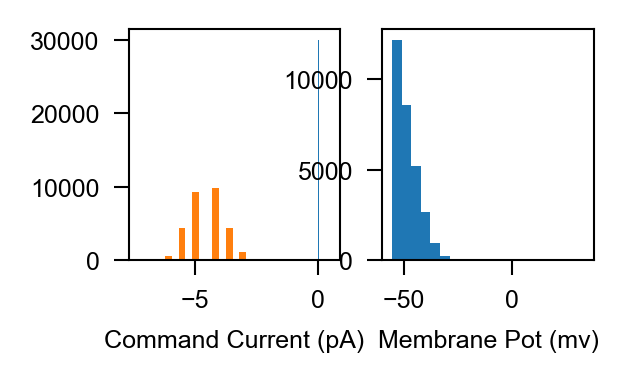

Analyzing I0 - 3min GapFree:   2%|█▎                                                    | 2/82 [00:00<00:13,  5.88it/s]

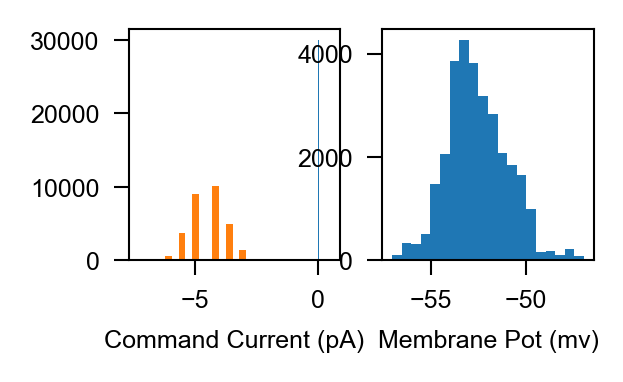

Analyzing I0 - 3min GapFree:   5%|██▋                                                   | 4/82 [00:00<00:16,  4.80it/s]

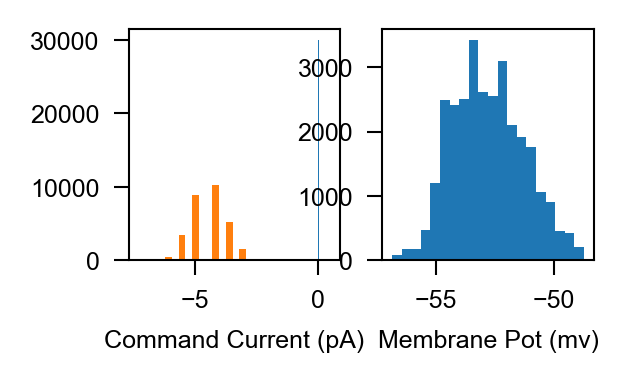

Analyzing I0 - 3min GapFree:   6%|███▎                                                  | 5/82 [00:01<00:23,  3.26it/s]

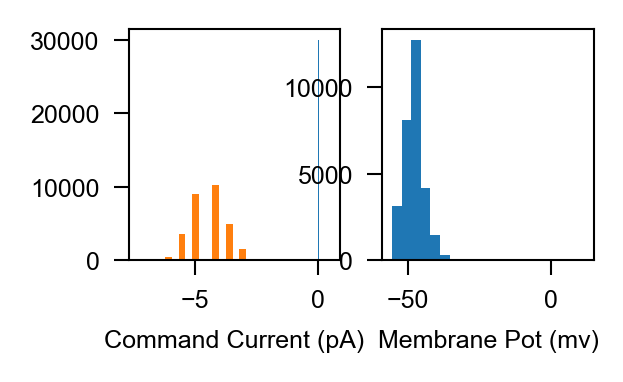

Analyzing I0 - 3min GapFree:   9%|████▌                                                 | 7/82 [00:01<00:20,  3.67it/s]

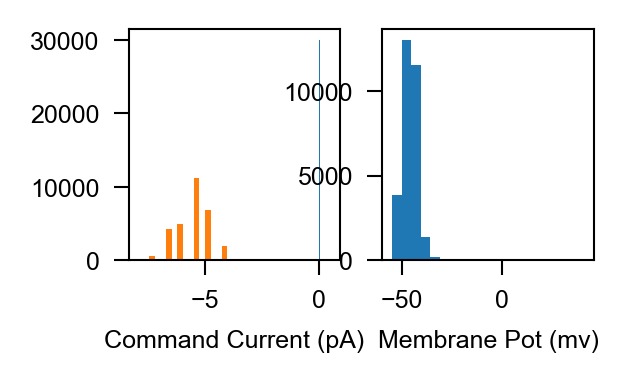

Analyzing I0 - 3min GapFree:  10%|█████▎                                                | 8/82 [00:02<00:21,  3.45it/s]

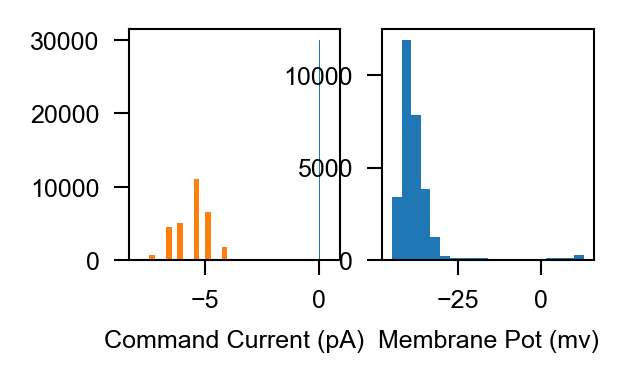

Analyzing I0 - 3min GapFree:  13%|███████                                              | 11/82 [00:02<00:14,  5.05it/s]

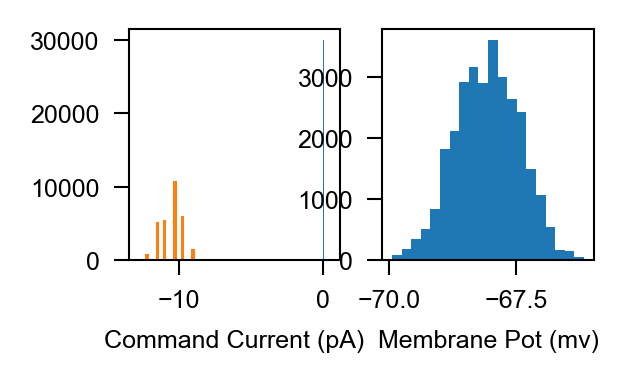

Analyzing I0 - 3min GapFree:  17%|█████████                                            | 14/82 [00:03<00:12,  5.41it/s]

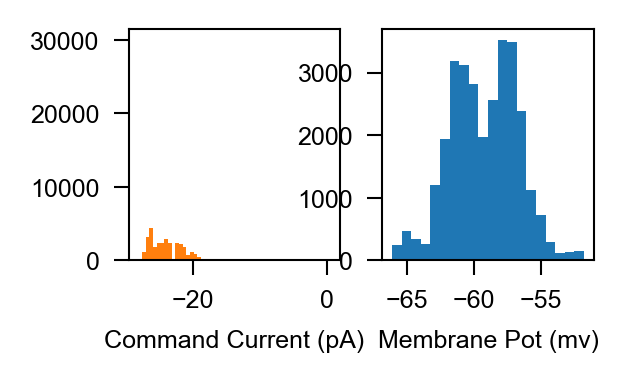

Analyzing I0 - 3min GapFree:  20%|██████████▎                                          | 16/82 [00:03<00:15,  4.16it/s]

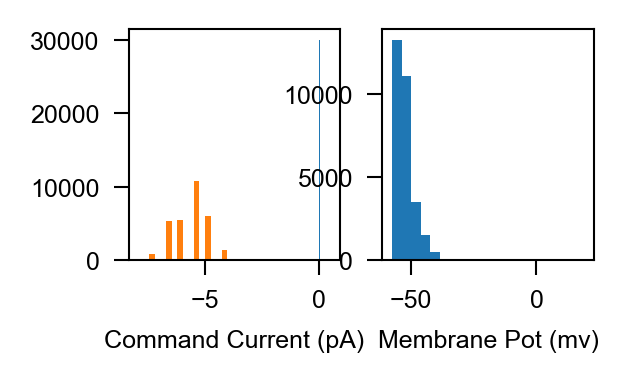

Analyzing I0 - 3min GapFree:  23%|████████████▎                                        | 19/82 [00:04<00:12,  5.03it/s]

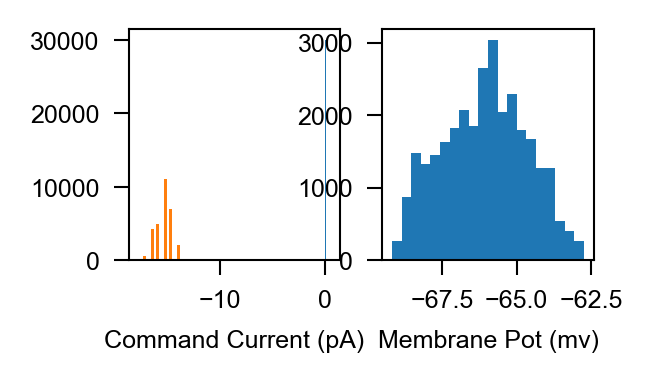

Analyzing I0 - 3min GapFree:  24%|████████████▉                                        | 20/82 [00:04<00:14,  4.41it/s]

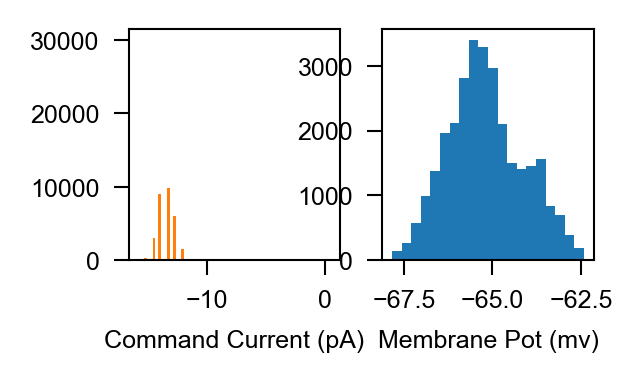

Analyzing I0 - 3min GapFree:  27%|██████████████▏                                      | 22/82 [00:05<00:14,  4.02it/s]

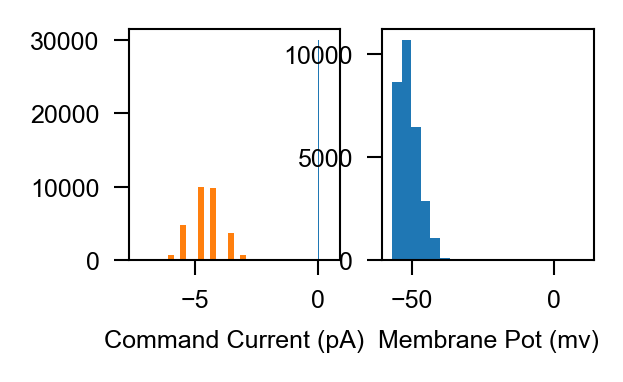

Analyzing I0 - 3min GapFree:  29%|███████████████▌                                     | 24/82 [00:05<00:13,  4.35it/s]

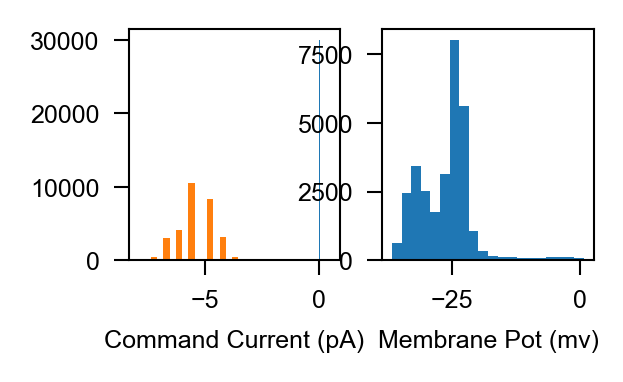

Analyzing I0 - 3min GapFree:  30%|████████████████▏                                    | 25/82 [00:05<00:14,  3.83it/s]

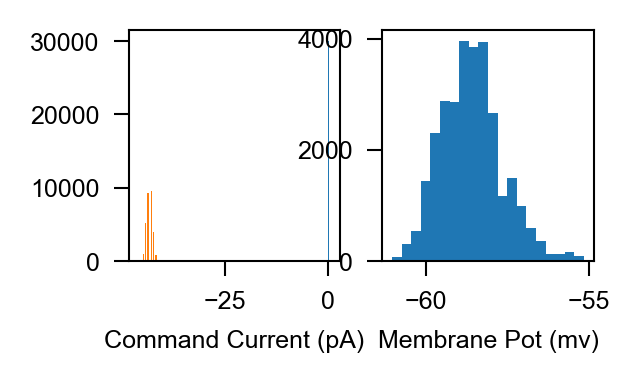

Analyzing I0 - 3min GapFree:  32%|████████████████▊                                    | 26/82 [00:06<00:18,  3.11it/s]

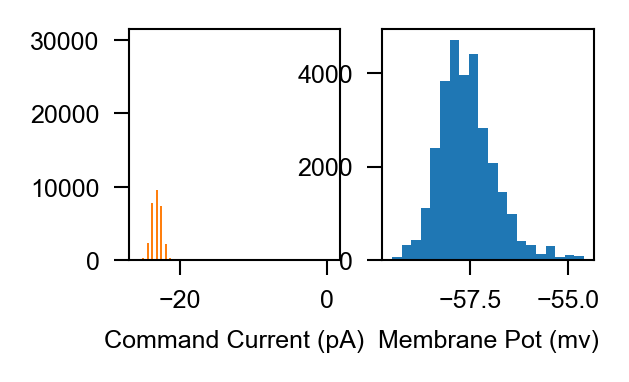

Analyzing I0 - 3min GapFree:  35%|██████████████████▋                                  | 29/82 [00:07<00:14,  3.77it/s]

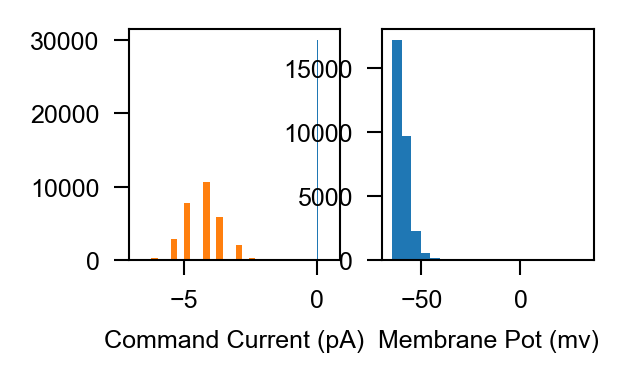

Analyzing I0 - 3min GapFree:  40%|█████████████████████▎                               | 33/82 [00:07<00:08,  5.56it/s]

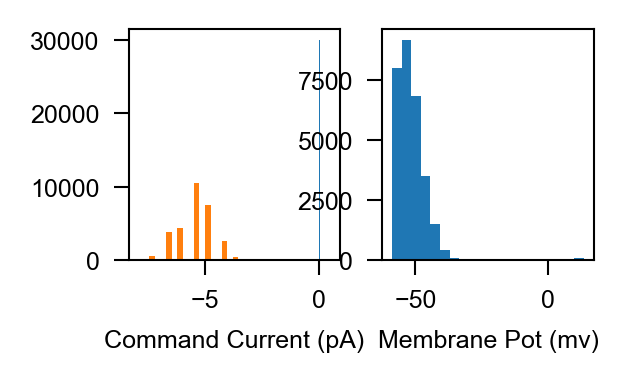

Analyzing I0 - 3min GapFree:  43%|██████████████████████▌                              | 35/82 [00:08<00:10,  4.53it/s]

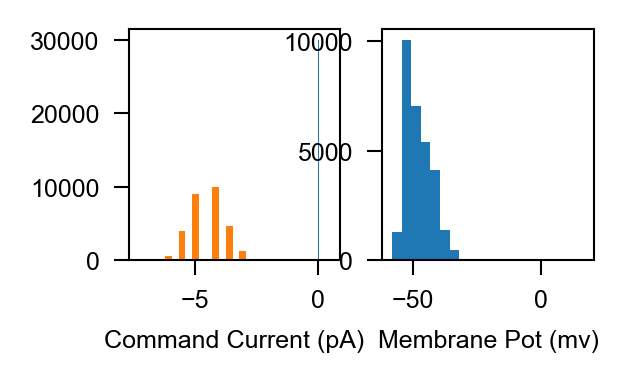

Analyzing I0 - 3min GapFree:  46%|████████████████████████▌                            | 38/82 [00:08<00:08,  5.42it/s]

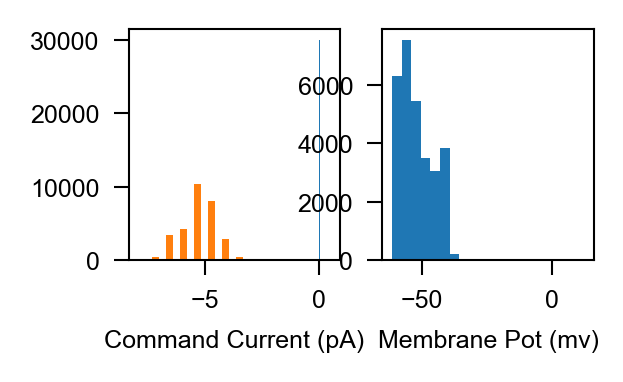

Analyzing I0 - 3min GapFree:  49%|█████████████████████████▊                           | 40/82 [00:09<00:09,  4.53it/s]

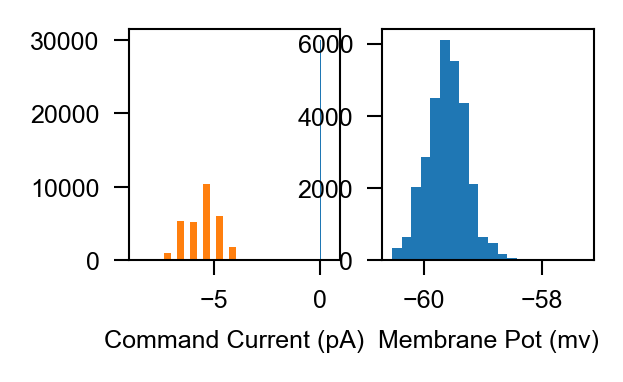

Analyzing I0 - 3min GapFree:  52%|███████████████████████████▊                         | 43/82 [00:09<00:09,  4.28it/s]

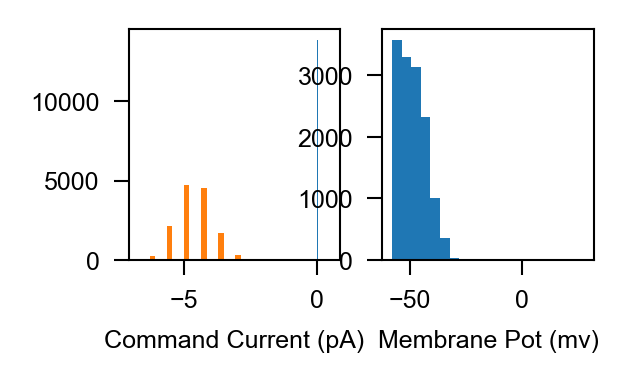

Analyzing I0 - 3min GapFree:  57%|██████████████████████████████▍                      | 47/82 [00:10<00:06,  5.67it/s]

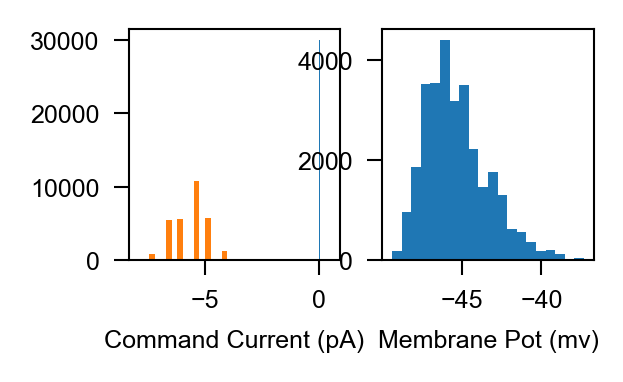

Analyzing I0 - 3min GapFree:  60%|███████████████████████████████▋                     | 49/82 [00:10<00:06,  4.94it/s]

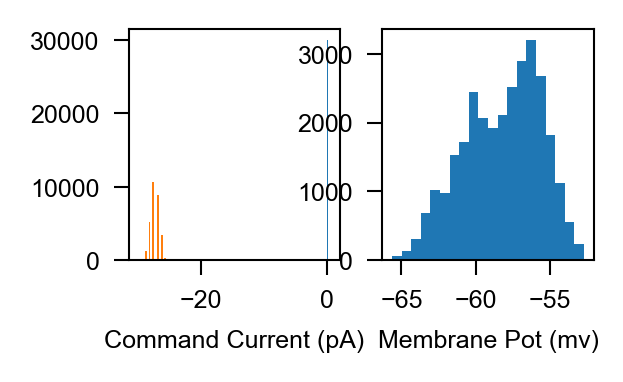

Analyzing I0 - 3min GapFree:  63%|█████████████████████████████████▌                   | 52/82 [00:11<00:05,  5.67it/s]

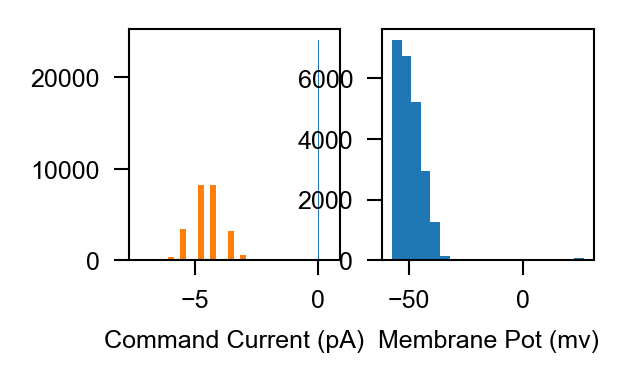

Analyzing I0 - 3min GapFree:  66%|██████████████████████████████████▉                  | 54/82 [00:11<00:04,  5.81it/s]

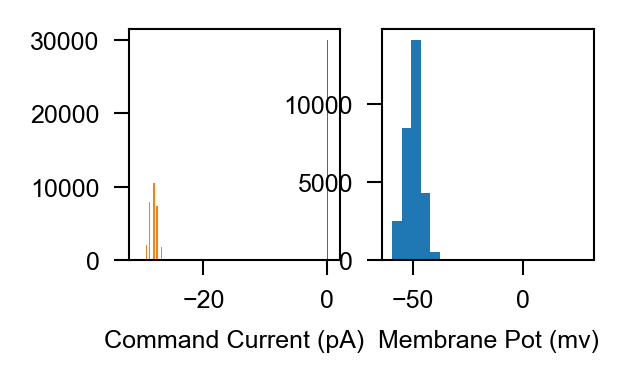

Analyzing I0 - 3min GapFree:  68%|████████████████████████████████████▏                | 56/82 [00:12<00:05,  4.99it/s]

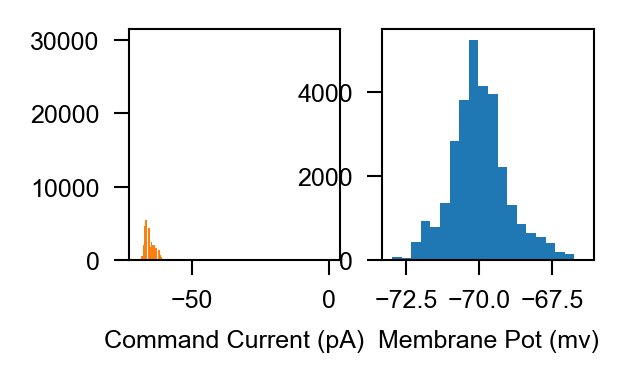

Analyzing I0 - 3min GapFree:  72%|██████████████████████████████████████▏              | 59/82 [00:12<00:04,  5.61it/s]

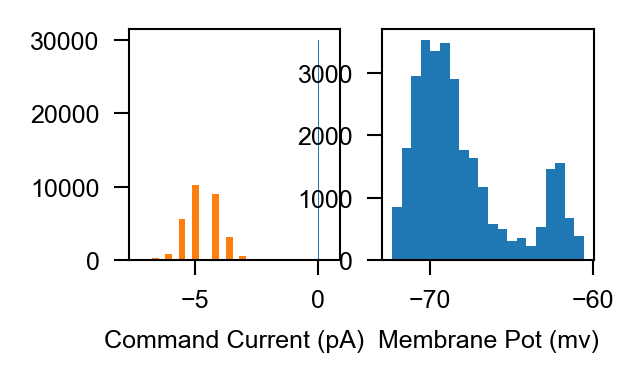

Analyzing I0 - 3min GapFree:  74%|███████████████████████████████████████▍             | 61/82 [00:12<00:03,  5.57it/s]

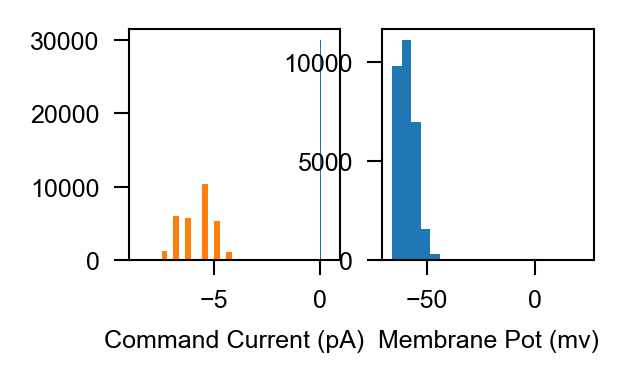

Analyzing I0 - 3min GapFree:  77%|████████████████████████████████████████▋            | 63/82 [00:13<00:04,  4.54it/s]

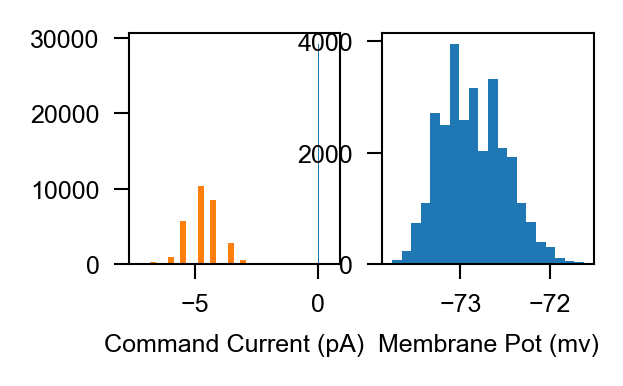

Analyzing I0 - 3min GapFree:  79%|██████████████████████████████████████████           | 65/82 [00:13<00:03,  4.86it/s]

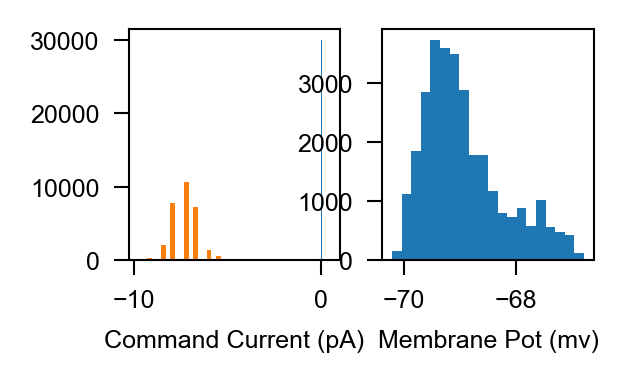

Analyzing I0 - 3min GapFree:  82%|███████████████████████████████████████████▎         | 67/82 [00:14<00:03,  4.90it/s]

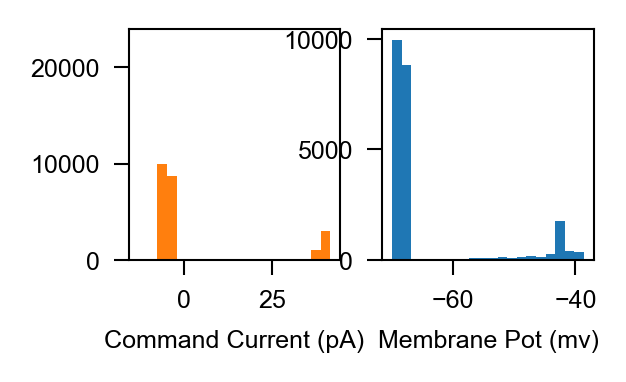

Analyzing I0 - 3min GapFree:  83%|███████████████████████████████████████████▉         | 68/82 [00:14<00:03,  4.48it/s]

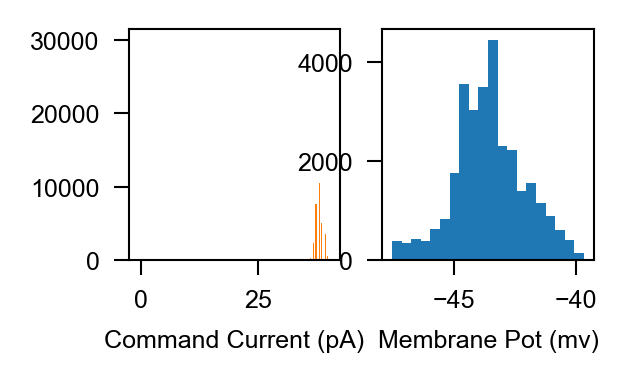

Analyzing I0 - 3min GapFree:  84%|████████████████████████████████████████████▌        | 69/82 [00:15<00:03,  3.39it/s]

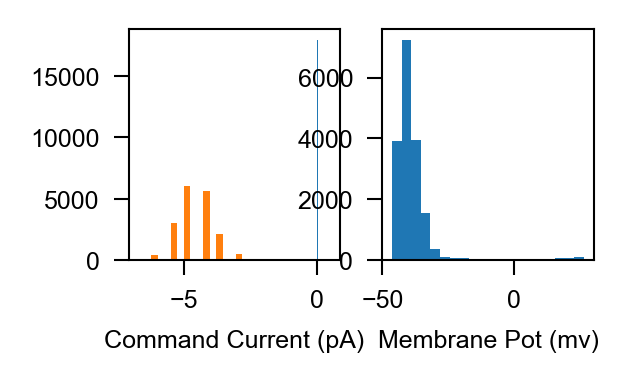

Analyzing I0 - 3min GapFree:  89%|███████████████████████████████████████████████▏     | 73/82 [00:15<00:01,  5.25it/s]

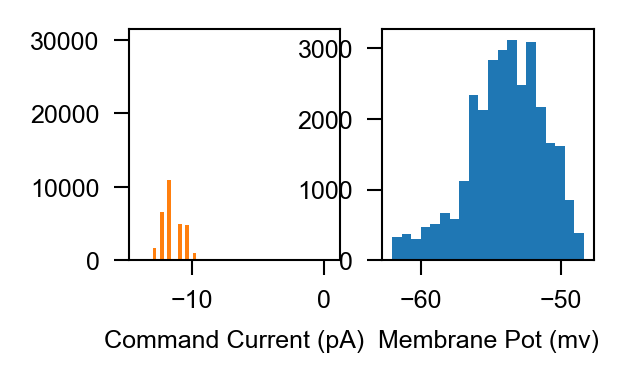

Analyzing I0 - 3min GapFree:  90%|███████████████████████████████████████████████▊     | 74/82 [00:16<00:02,  3.96it/s]

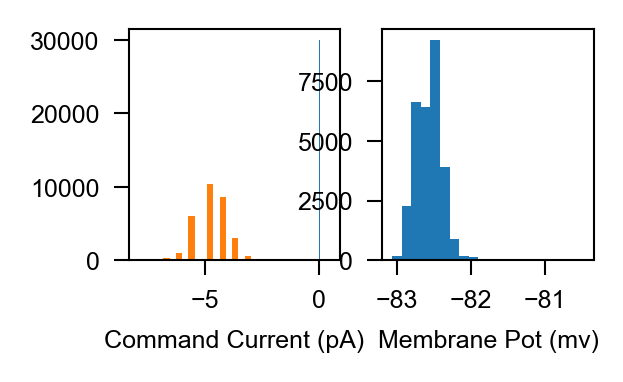

Analyzing I0 - 3min GapFree:  93%|█████████████████████████████████████████████████    | 76/82 [00:16<00:01,  4.36it/s]

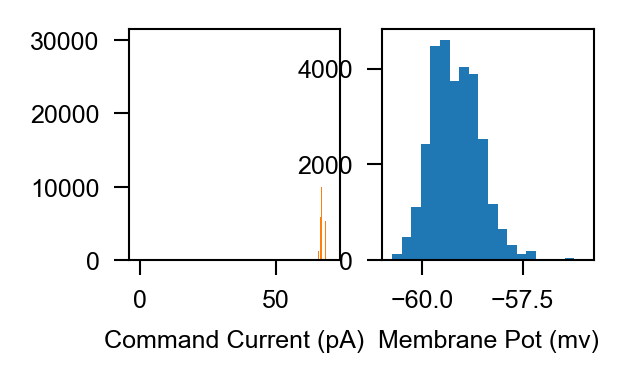

Analyzing I0 - 3min GapFree:  94%|█████████████████████████████████████████████████▊   | 77/82 [00:17<00:01,  3.31it/s]

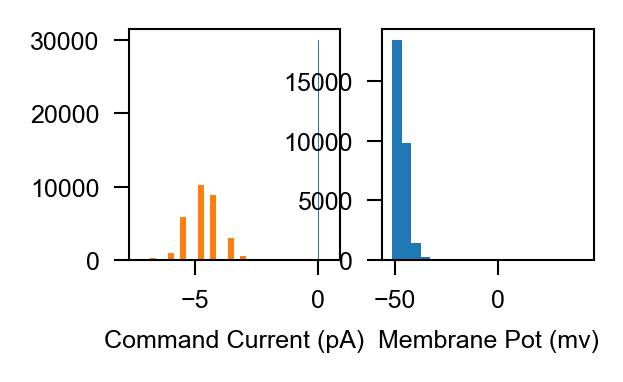

Analyzing I0 - 3min GapFree:  98%|███████████████████████████████████████████████████▋ | 80/82 [00:17<00:00,  4.58it/s]

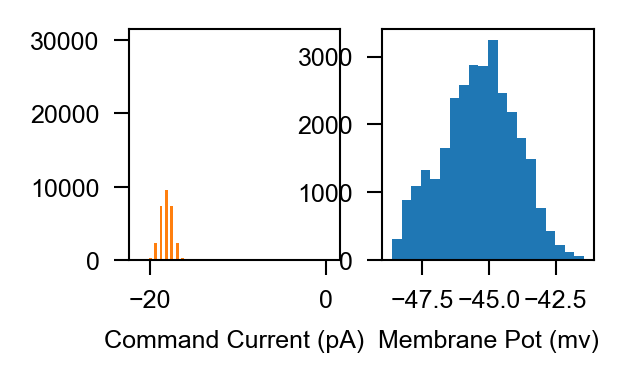

Analyzing IC - Gain - D10pA:   0%|                                                              | 0/31 [00:00<?, ?it/s]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)


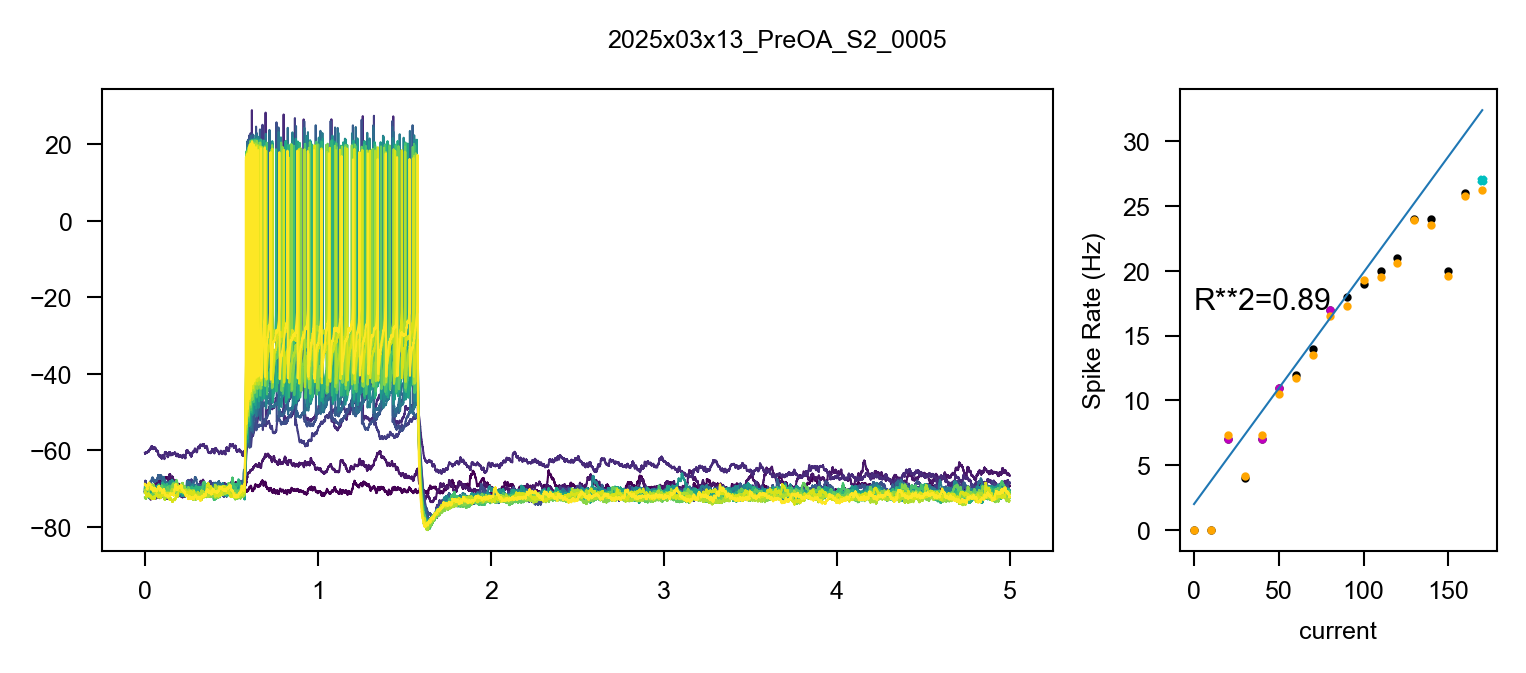

Analyzing IC - Gain - D10pA:   6%|███▍                                                  | 2/31 [00:04<01:02,  2.14s/it]C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\1718039341.py:2: RuntimeWarning: divide by zero encountered in divide
  isi_ratio = (spike_counts/isi_rates)


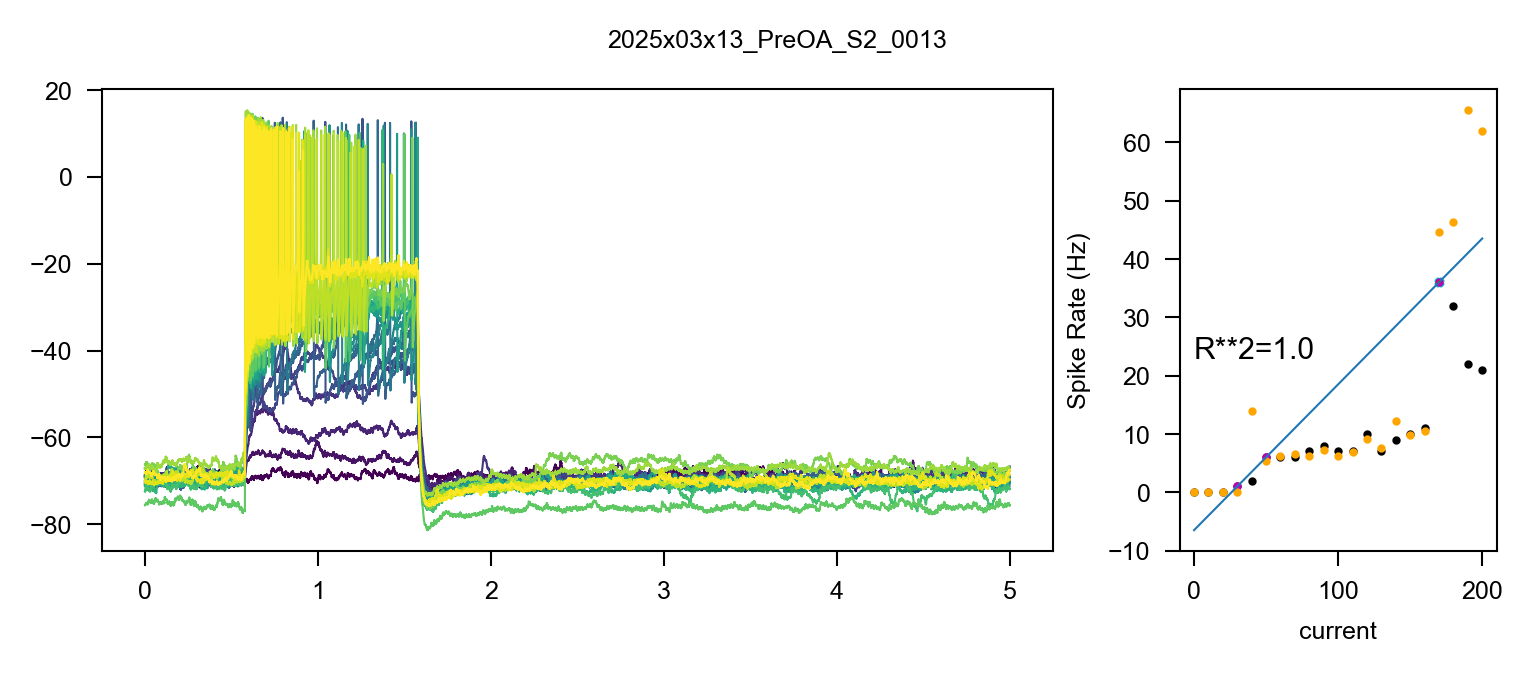

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: divide by zero encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  10%|█████▏                                                | 3/31 [00:09<01:34,  3.39s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Use

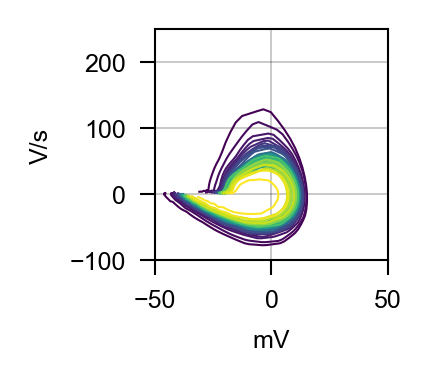

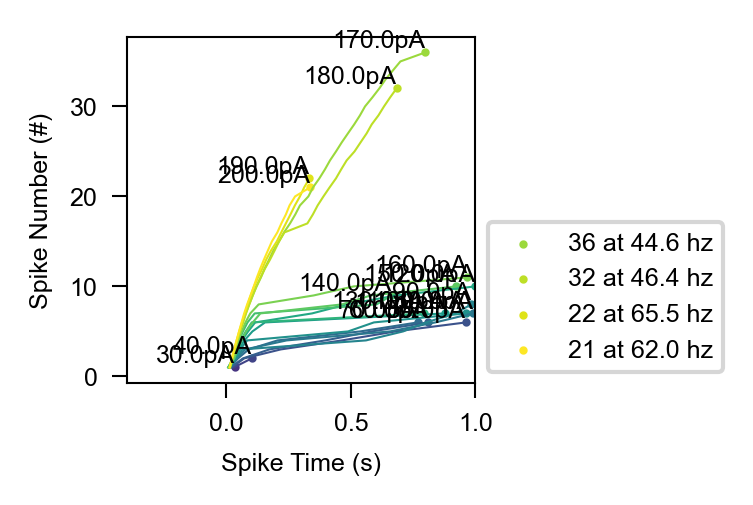

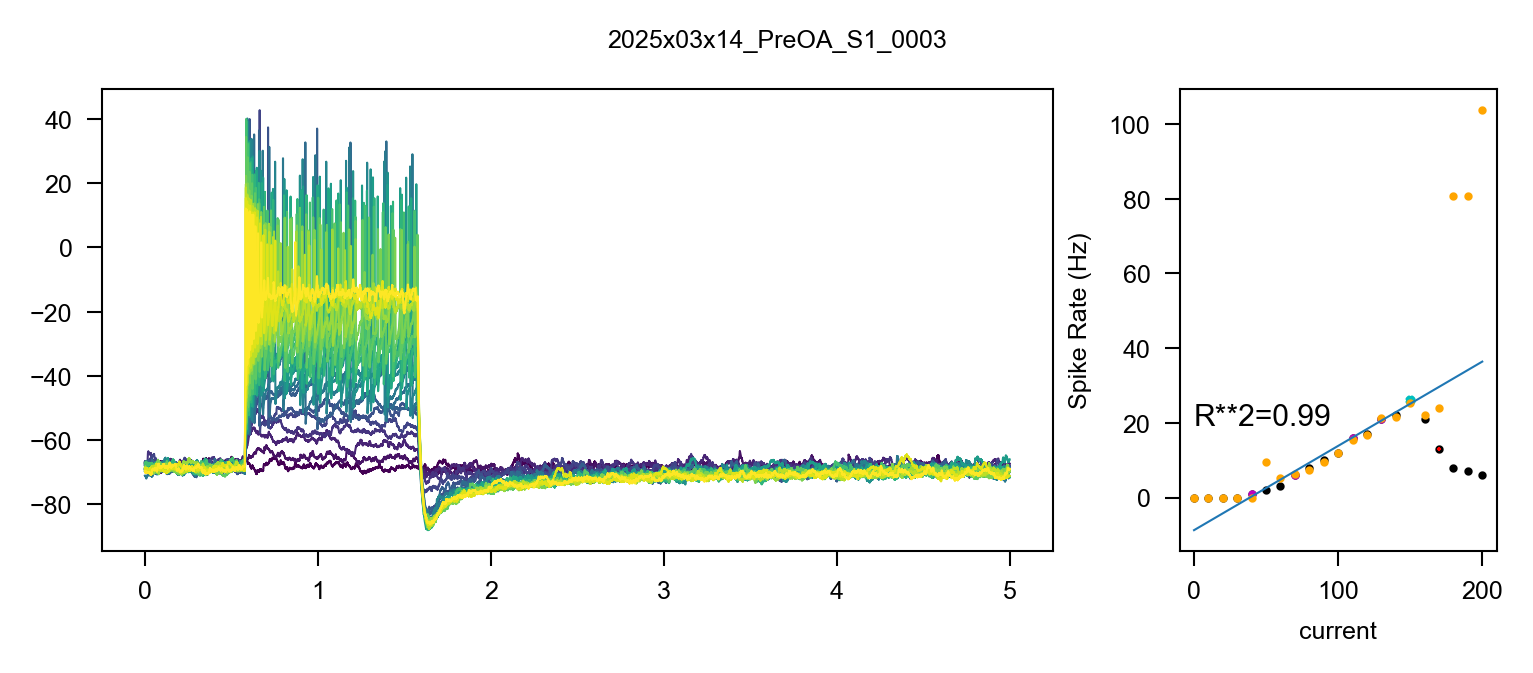

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: divide by zero encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  13%|██████▉                                               | 4/31 [00:14<01:53,  4.20s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Use

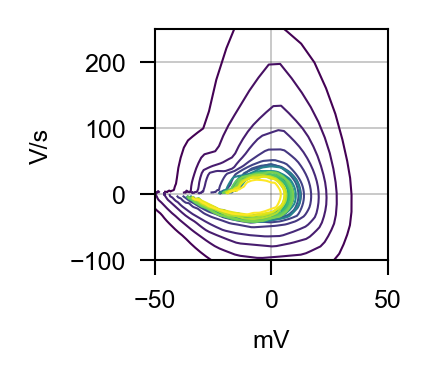

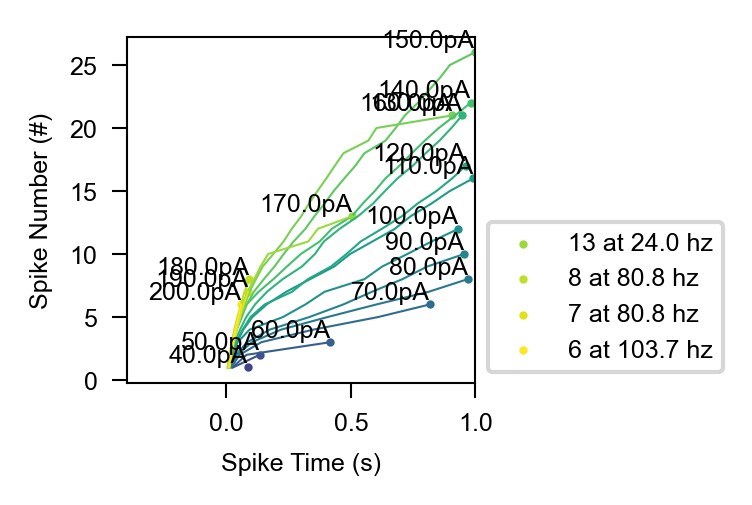

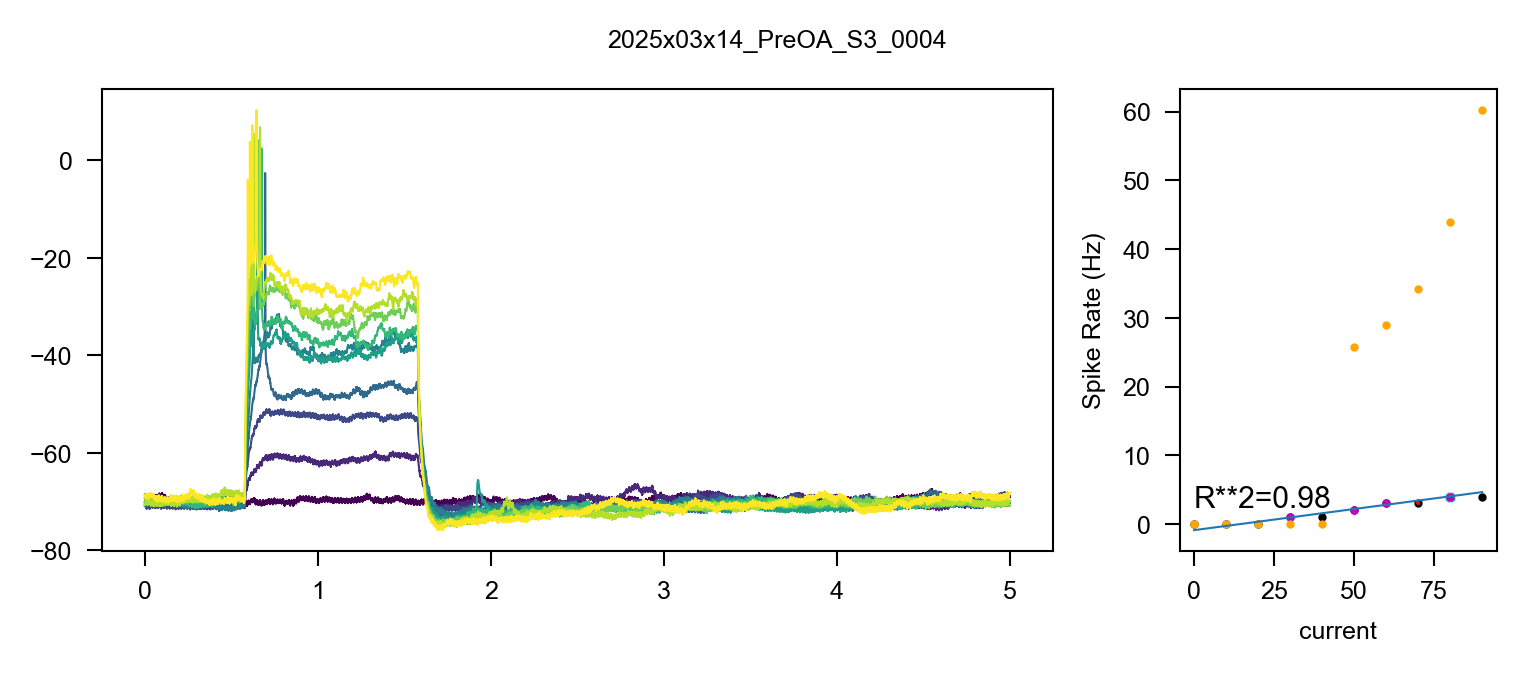

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: divide by zero encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  19%|██████████▍                                           | 6/31 [00:18<01:10,  2.83s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Use

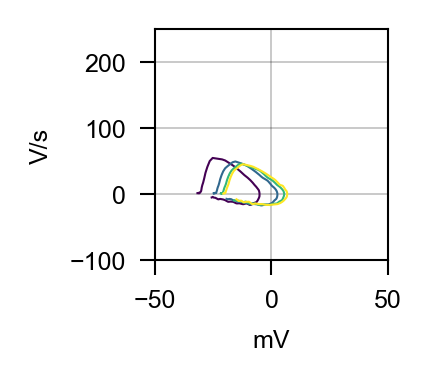

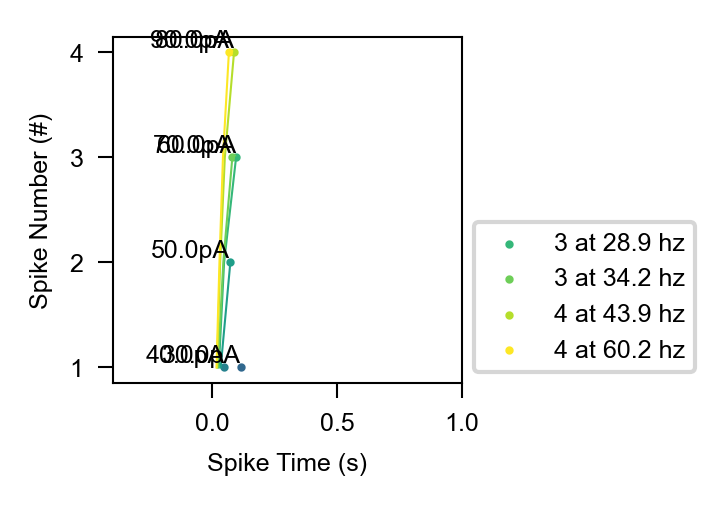

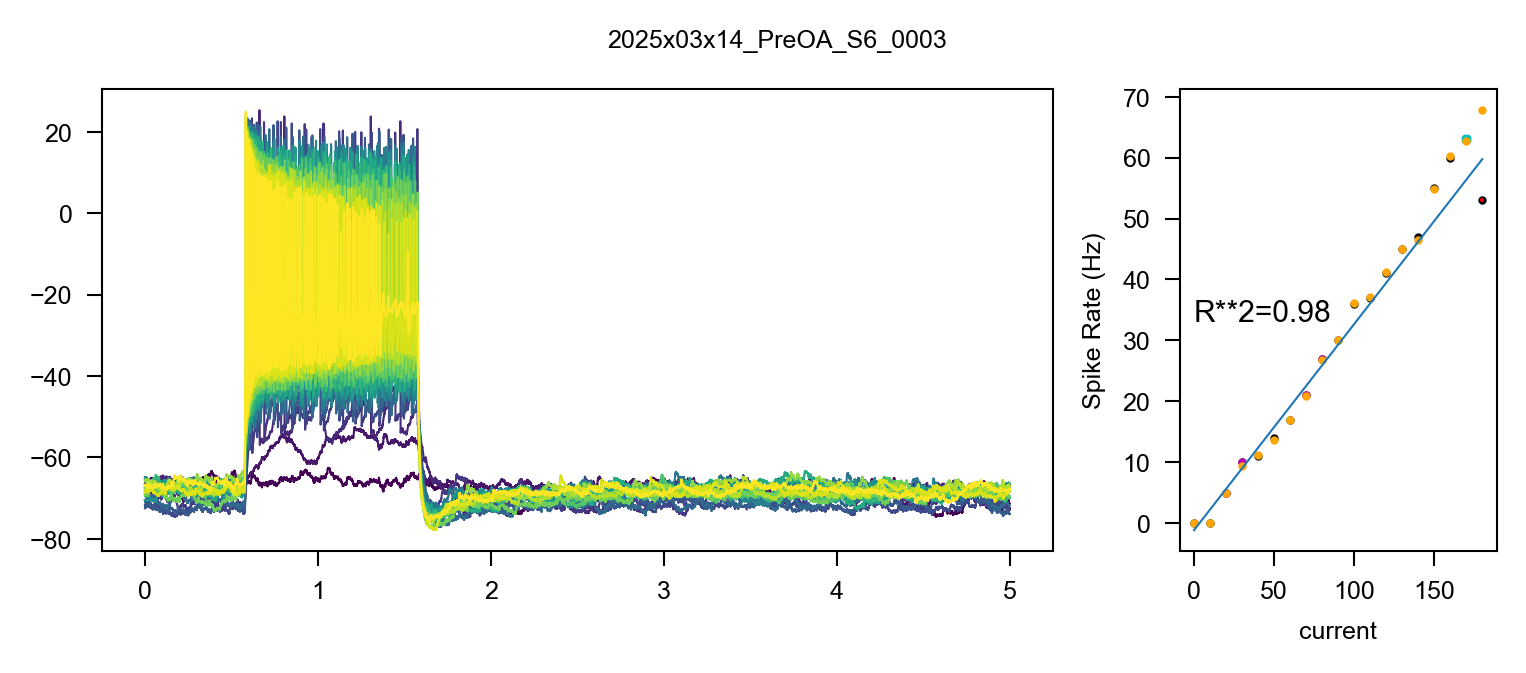

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  23%|████████████▏                                         | 7/31 [00:22<01:21,  3.38s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)


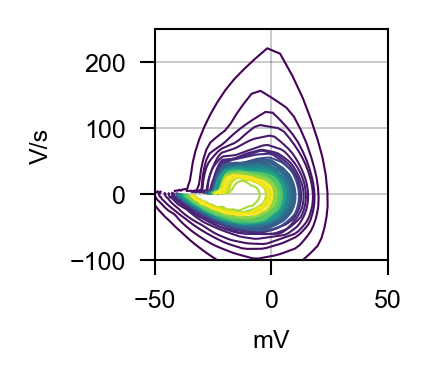

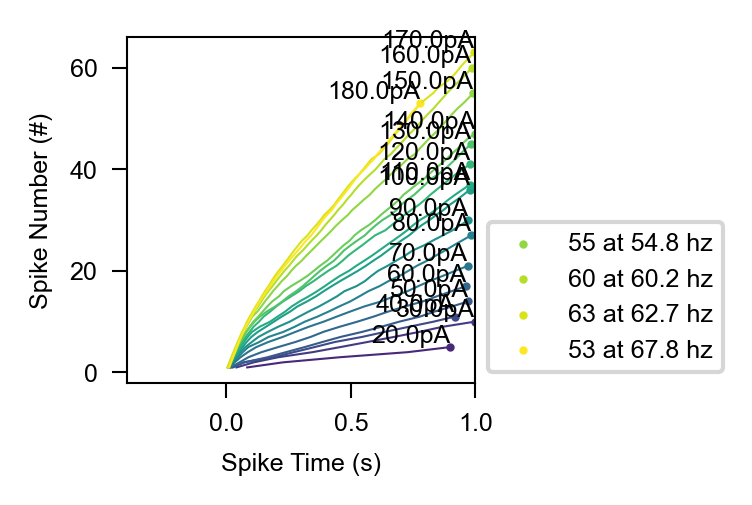

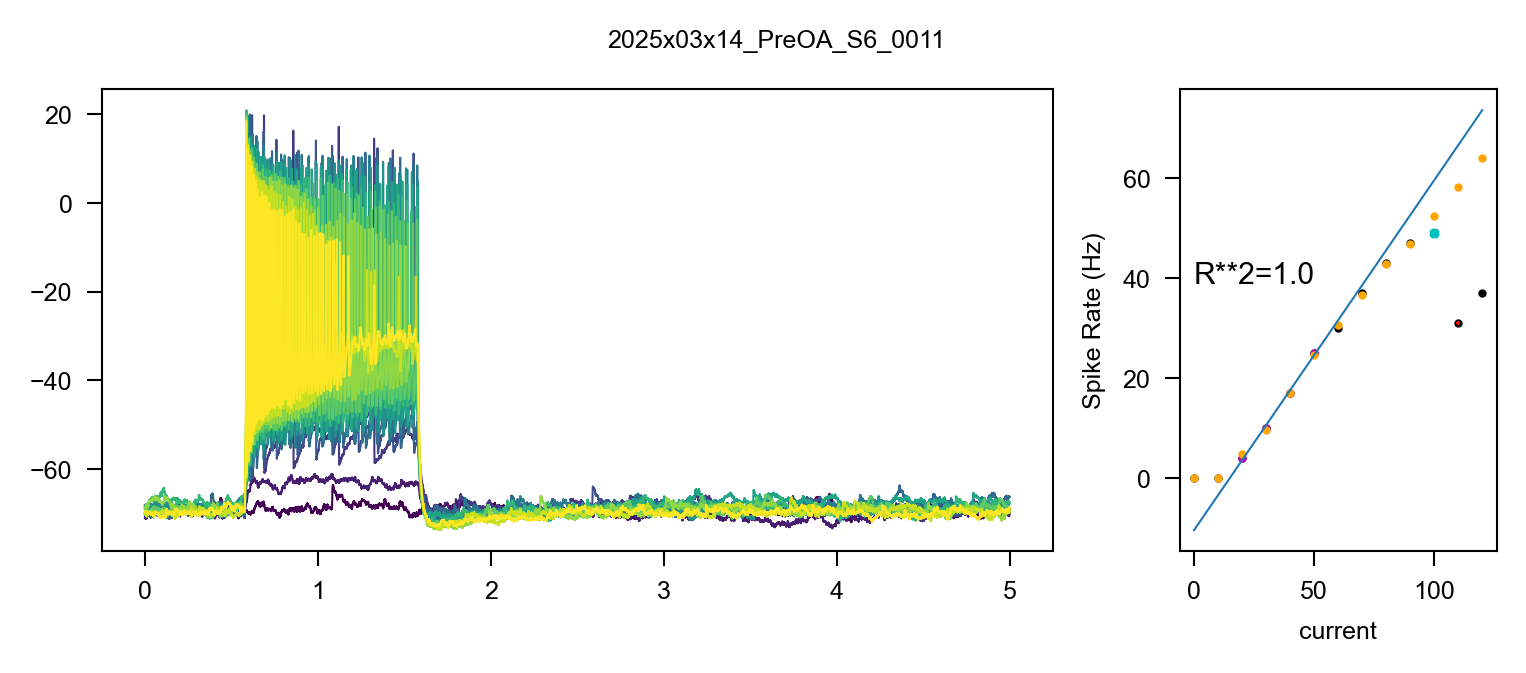

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  26%|█████████████▉                                        | 8/31 [00:26<01:20,  3.51s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)


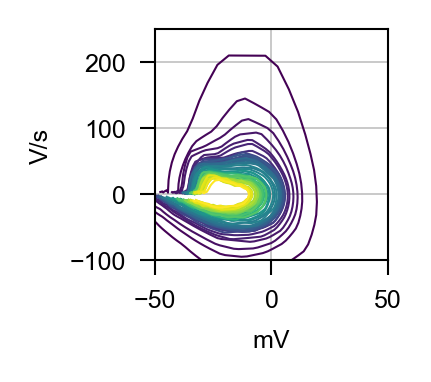

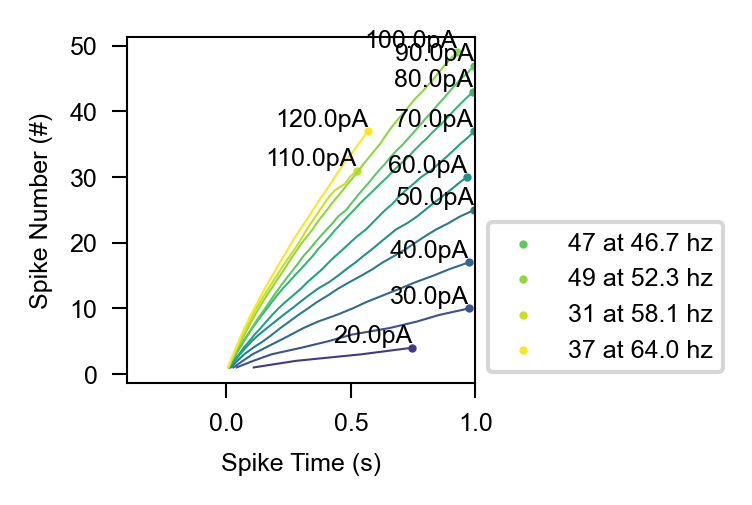

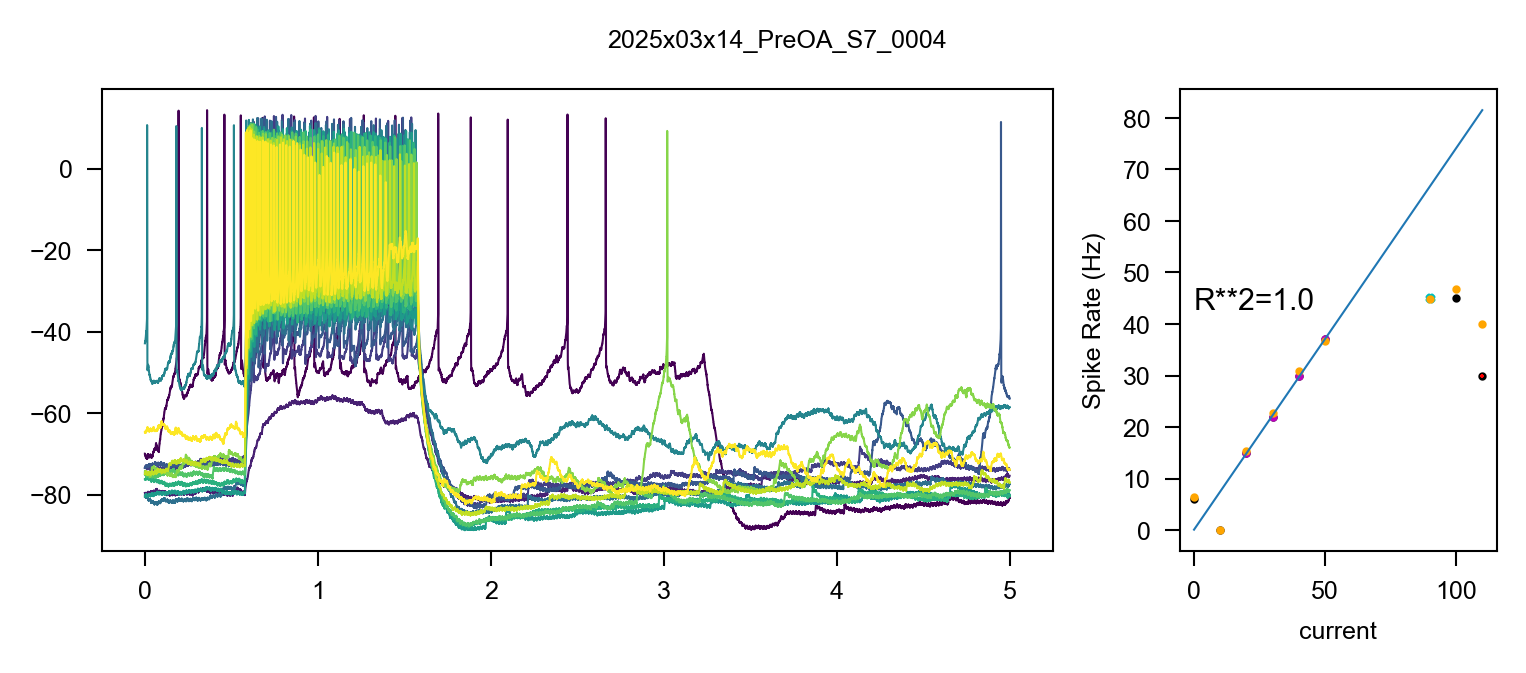

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  29%|███████████████▋                                      | 9/31 [00:30<01:19,  3.62s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)


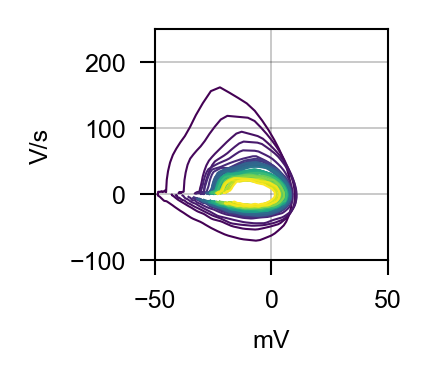

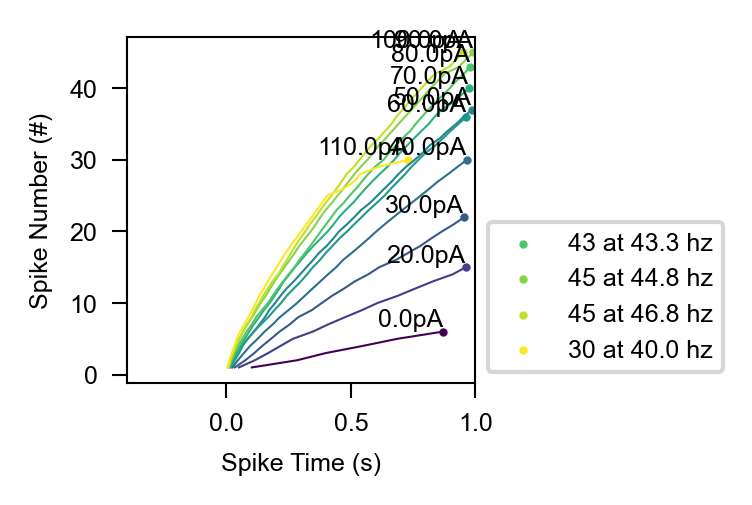

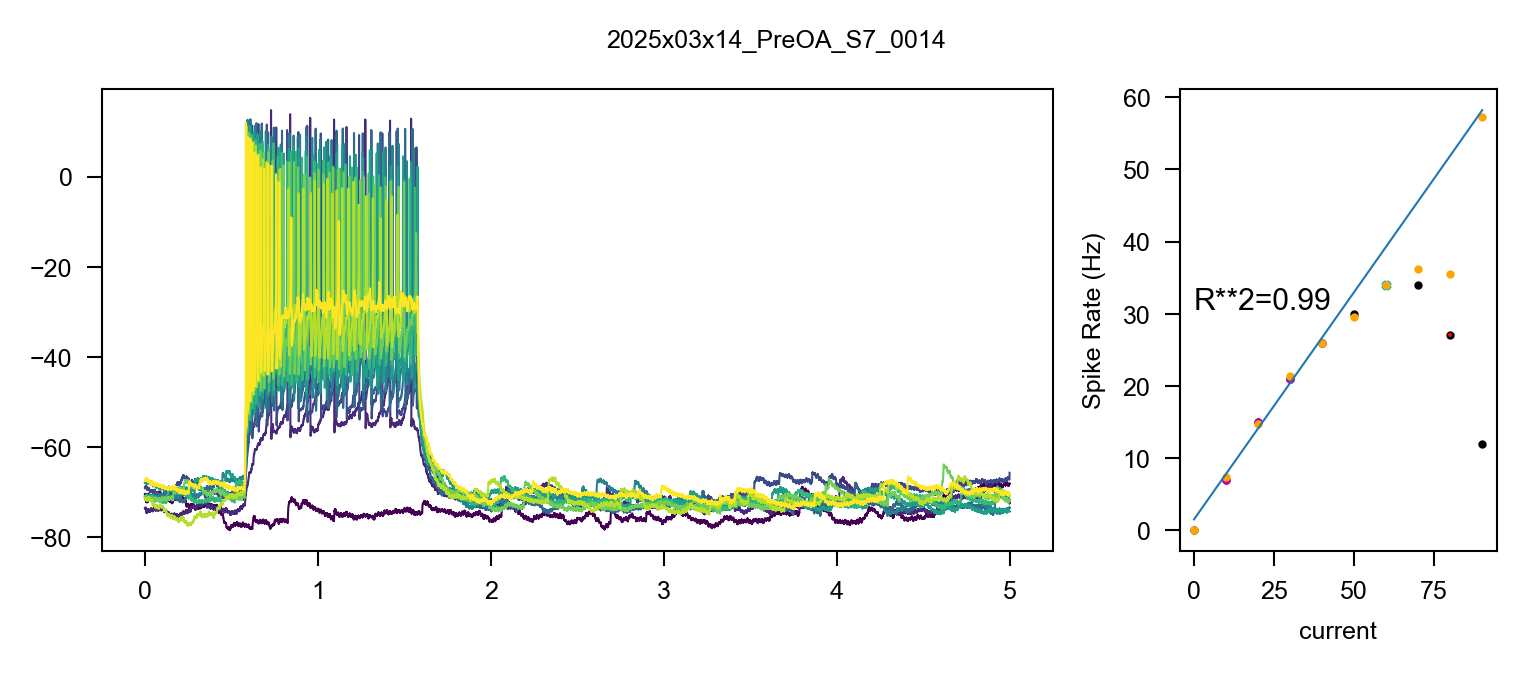

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  32%|█████████████████                                    | 10/31 [00:33<01:13,  3.50s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)


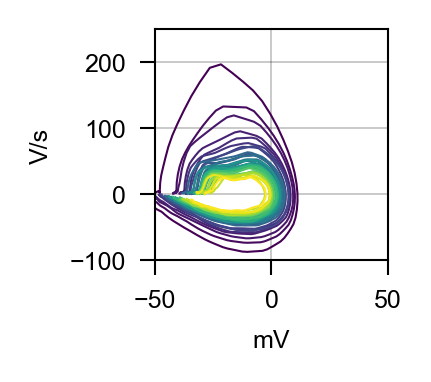

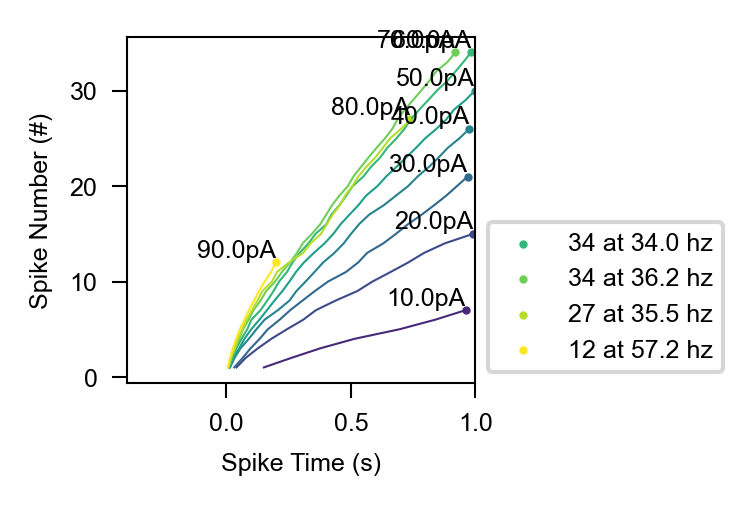

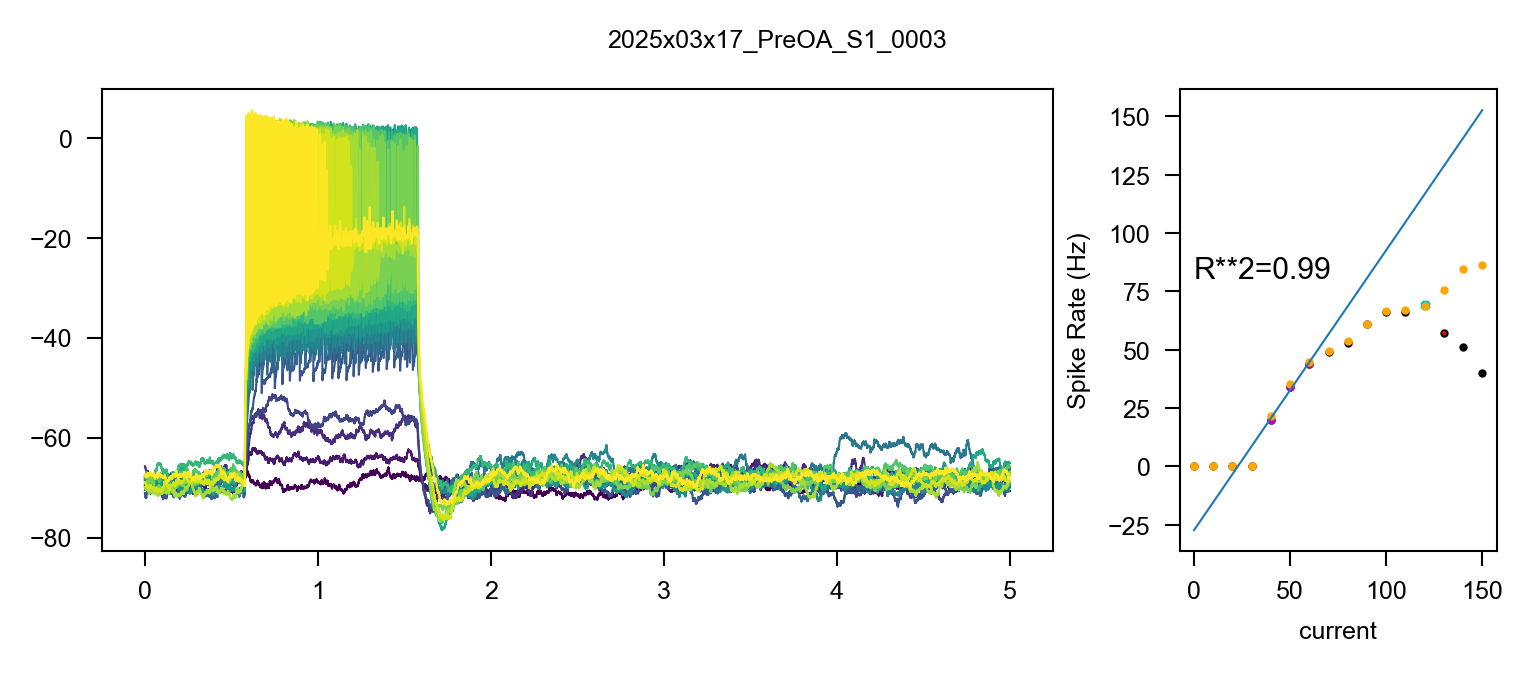

Analyzing IC - Gain - D10pA:  35%|██████████████████▊                                  | 11/31 [00:38<01:13,  3.68s/it]

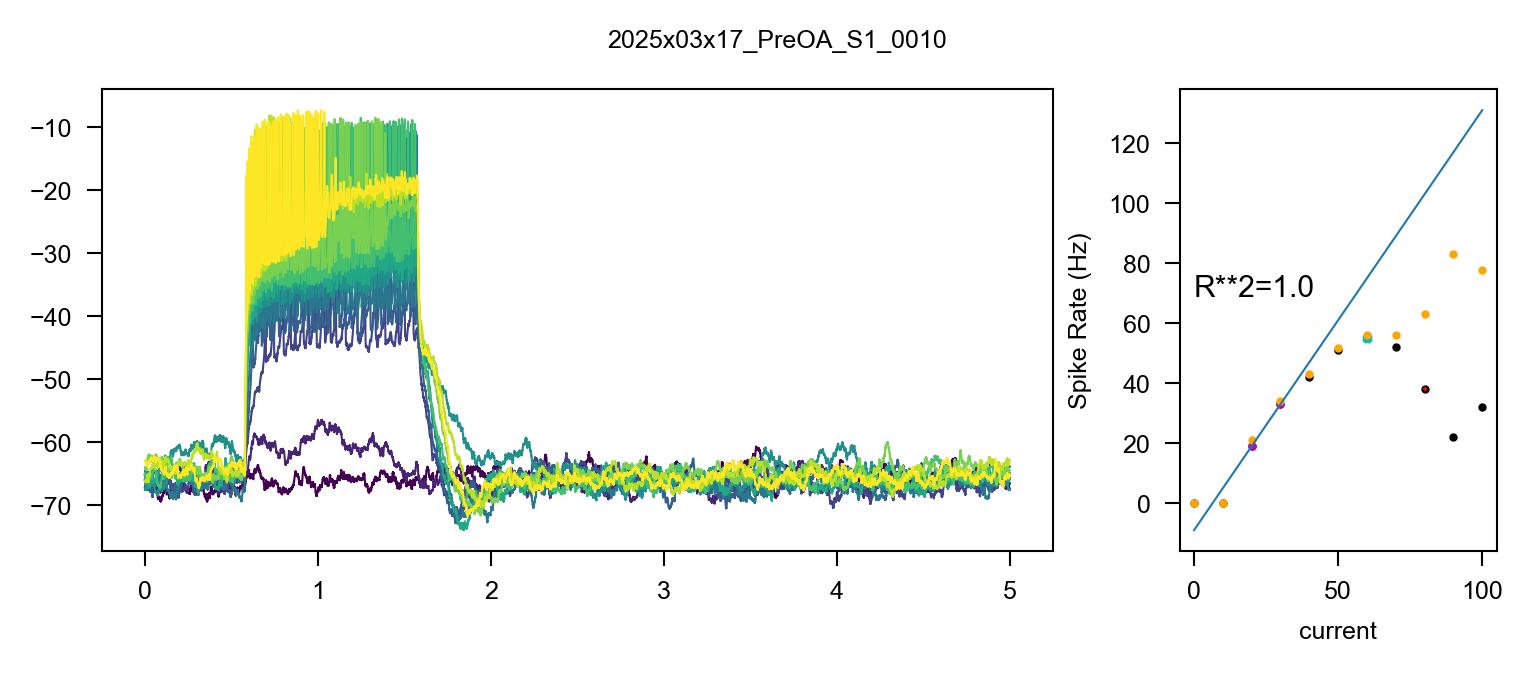

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  39%|████████████████████▌                                | 12/31 [00:42<01:13,  3.86s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)


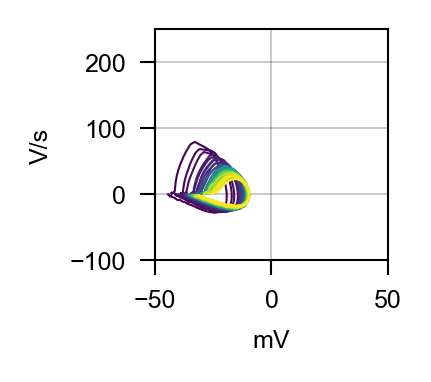

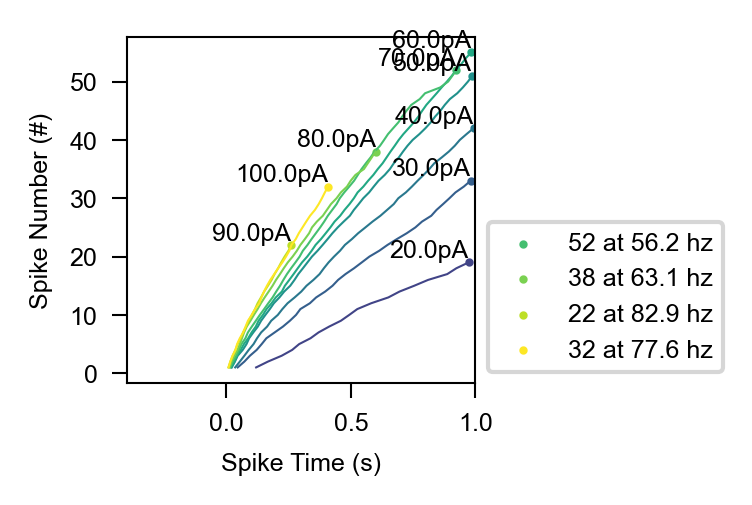

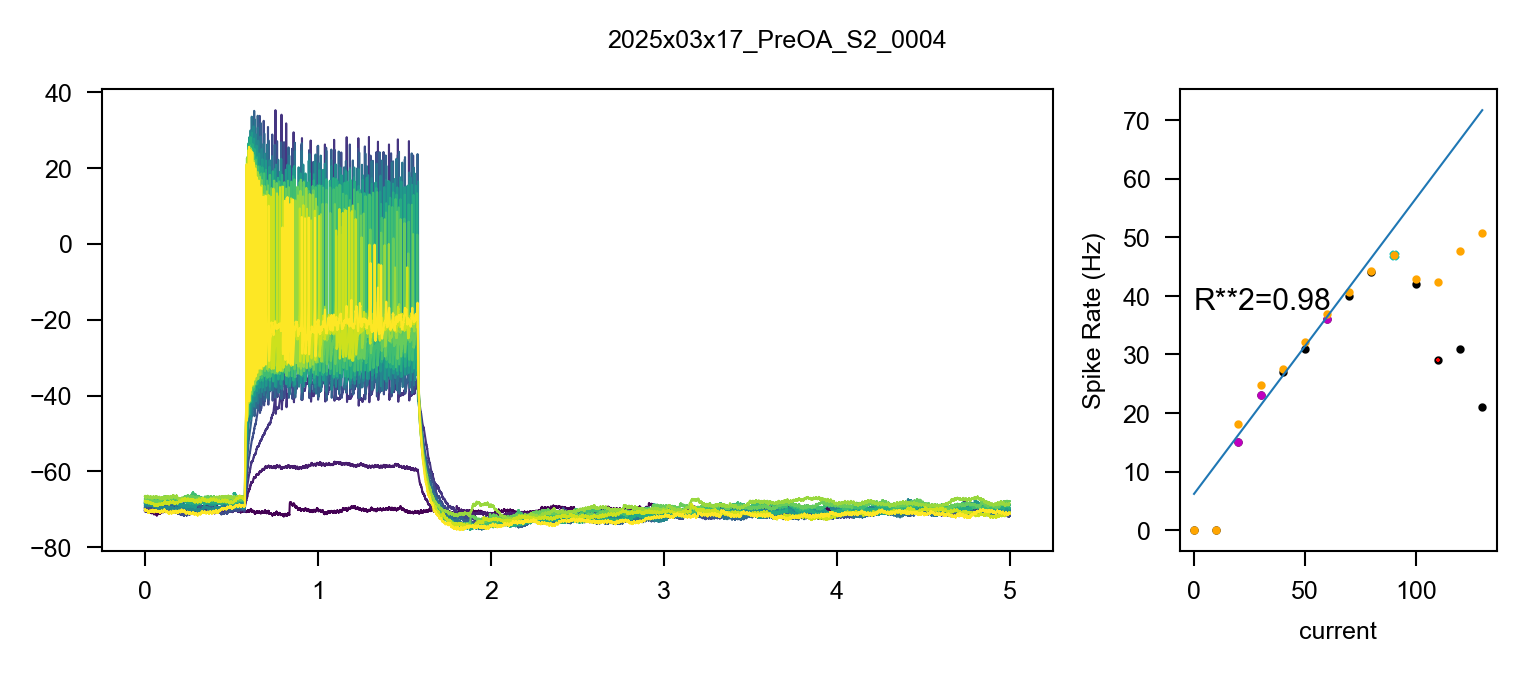

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  42%|██████████████████████▏                              | 13/31 [00:46<01:10,  3.93s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)


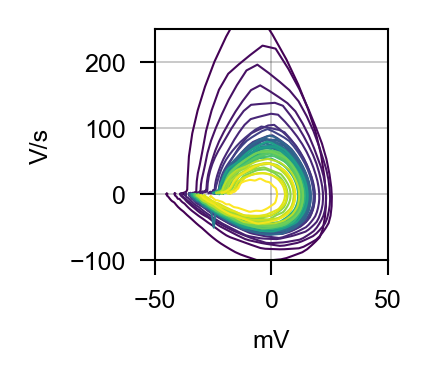

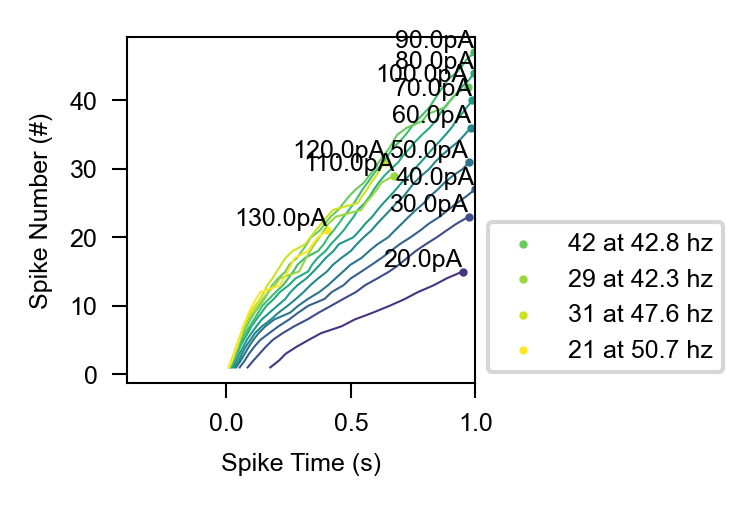

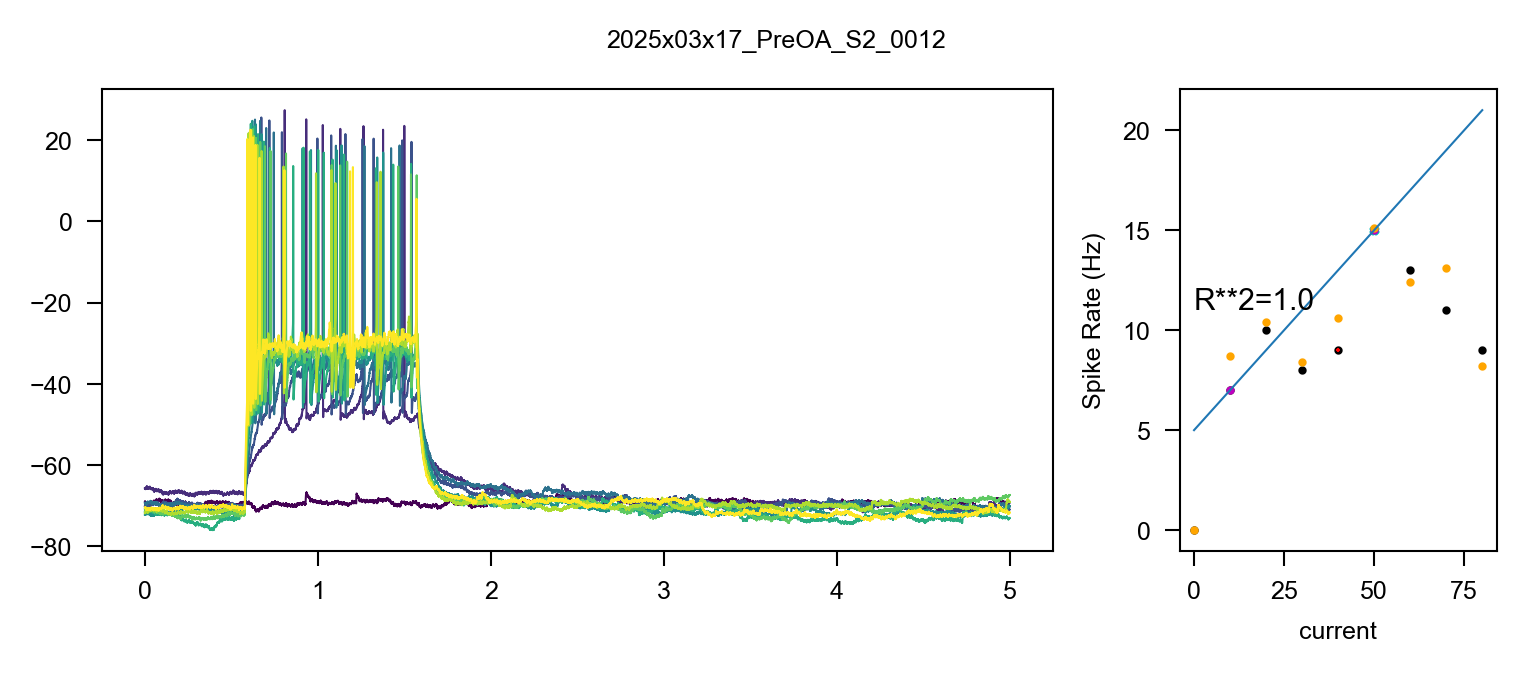

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  45%|███████████████████████▉                             | 14/31 [00:49<01:02,  3.68s/it]C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dennis.tabuena\AppData\Local\anaconda3\envs\notebook\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)


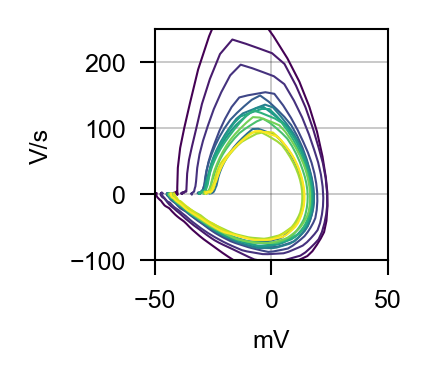

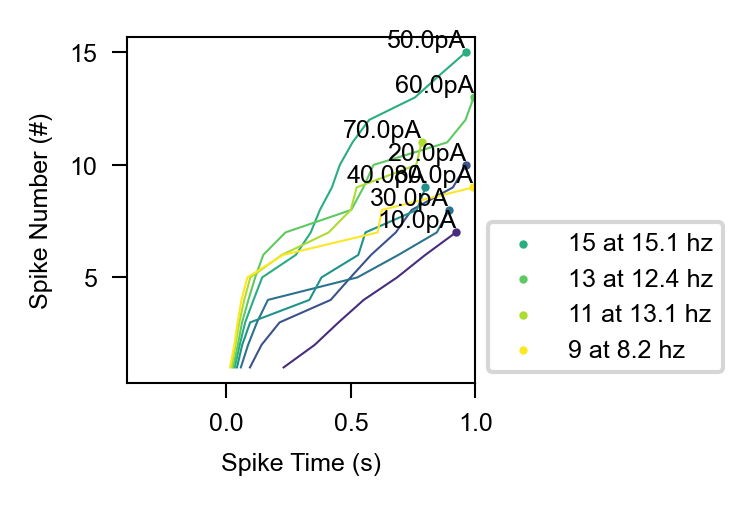

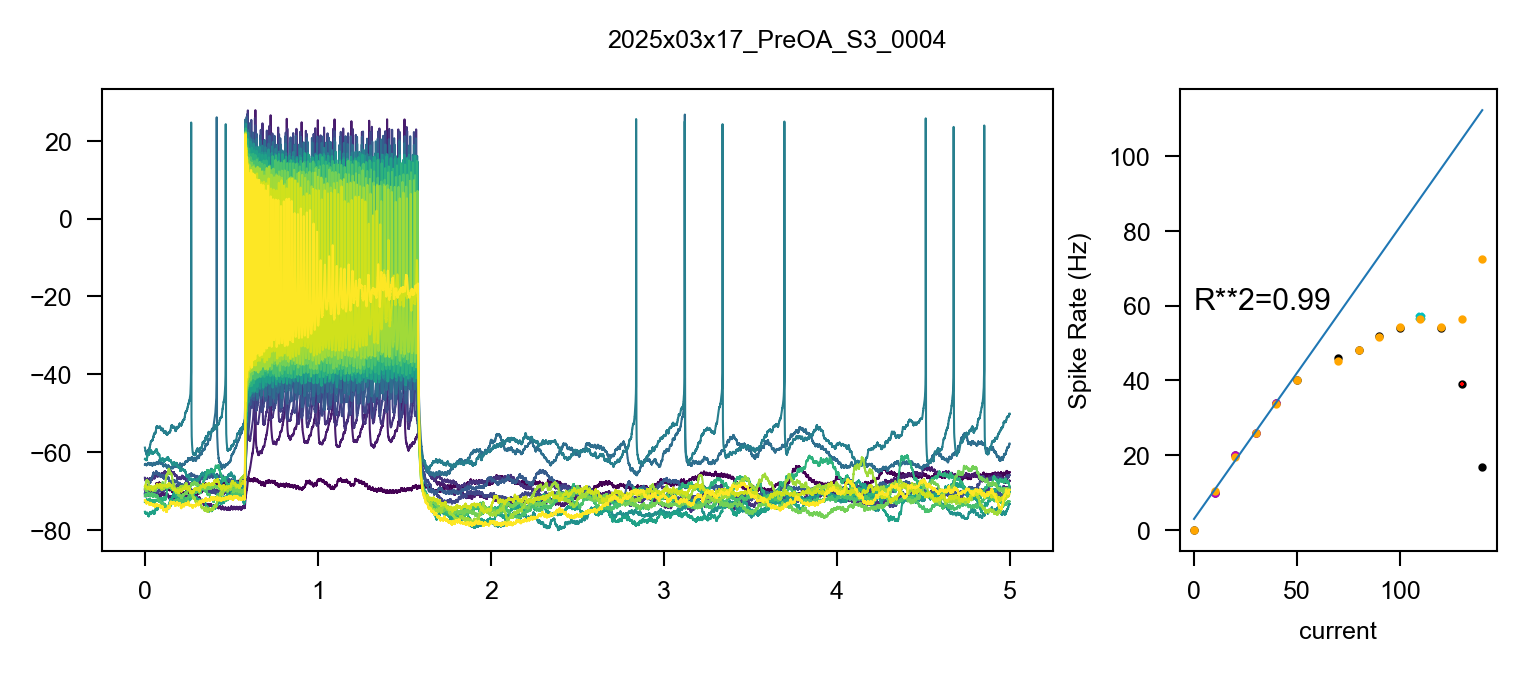

C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_10612\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]
Analyzing IC - Gain - D10pA:  48%|█████████████████████████▋                           | 15/31 [00:53<01:01,  3.83s/it]

In [ ]:
consolidated_results, problem_records = execute_analysis_suite(protocol_groups, protocol_analyzers)


In [ ]:
display(consolidated_results['rmp_results'])

In [275]:
# # abf = pyabf.ABF(r'C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\Recs\2025x03x13\2025x03x13_PreOA_S2_0003.abf')
# # IV_analyzer(
# #     abf,
# #     Na_window=(16, 30),       # time window [ms] for measuring Na (peak)
# #     K_window=(100, 120),      # time window [ms] for measuring K (steady-state)
# #     to_plot=True,
# #     figopt={'type': 'jpg', 'dpi': 300}
# )

In [ ]:

import numpy as np
import pandas as pd

def flatten_stim_dict_col(df: pd.DataFrame, dict_col: str, suffix="pA") -> pd.DataFrame:
    """
    Given a DataFrame 'df' and a column name 'dict_col' that contains dictionaries
    of the form {stim_current: measurement_value},
    this function expands each dictionary item into a new column in 'df'.

    For example, if row i has:
        df[dict_col] = {5.0: 10, 10.0: 20}
    then we create new columns:
        dict_col_5.0pA, dict_col_10.0pA
    in row i with values 10 and 20 respectively.

    Any stimulus keys not present in a row's dictionary become NaN in that row.
    All keys from all rows become columns.

    Parameters
    ----------
    df : pd.DataFrame
        Your input DataFrame.
    dict_col : str
        Column in 'df' that contains a dict, e.g. {stim_value: some_measurement}.
    suffix : str, optional
        Suffix appended to each stimulus level in the new column names.
        Defaults to 'pA'.

    Returns
    -------
    pd.DataFrame
        The same DataFrame (modified in-place) but with additional columns
        for each dictionary key. The original 'dict_col' is preserved unless
        you explicitly drop it.
    """
    # 1) Collect all unique keys (stim currents) across every row's dictionary
    all_keys = set()
    for val in df[dict_col]:
        if isinstance(val, dict):
            all_keys.update(val.keys())

    # 2) For each unique key, create a new column
    #    named like "dict_col_{key}pA"
    for key in sorted(all_keys):
        col_name = f"{dict_col}_{key}{suffix}"
        df[col_name] = df[dict_col].apply(
            lambda d: d.get(key, np.nan) if isinstance(d, dict) else np.nan
        )

    # If you prefer to remove the original dictionary column:
    # df.drop(columns=[dict_col], inplace=True)

    return df


In [ ]:


for k,v in problem_records.items():
    print(k,v)

consolidated_results_wide = consolidated_results.copy()
consolidated_results_wide['gain_results'] = flatten_stim_dict_col(consolidated_results_wide['gain_results'], 'Spike_Counts')
consolidated_results_wide['IV_results_V2'] = flatten_stim_dict_col(consolidated_results_wide['IV_results_V2'], 'Na_(16.5, 30)')
consolidated_results_wide['IV_results_V2'] = flatten_stim_dict_col(consolidated_results_wide['IV_results_V2'], 'K_(139, 149)')
for k,v in consolidated_results_wide.items():
    print(k)
    v.to_csv(f'{k}.csv')

In [ ]:
def get_paired_data(df, col):
    # Filter rows where 'condition' is 'control' or 'drug'
    filtered_df = df[df['condition'].isin(['control', 'drug'])]

    # Pivot the DataFrame with aggregation to handle duplicates
    # pivot_df = filtered_df.pivot_table(index='cell_id', columns='condition', values=col, aggfunc='mean')
    pivot_df = filtered_df.pivot_table(index=['cell_id', 'sample'], columns='condition', values=col, aggfunc='mean')


    # Rename the columns to include the original column name and condition
    pivot_df.columns = [f"{col}_{cond}" for cond in pivot_df.columns]

    return pivot_df.reset_index()

def process_consolidated_results(consolidated_results_wide, columns_dict):
    processed_results = {}

    for key, df in consolidated_results_wide.items():
        if key in columns_dict:
            for col in columns_dict[key]:
                paired_df = get_paired_data(df, col)
                paired_df = norm_paired_df(paired_df, col)
                processed_results[f"{key}_{col}"] = paired_df

    return processed_results


def norm_paired_df(paired_df, col):
    control_col = f"{col}_control"
    drug_col = f"{col}_drug"
    ratio_col = f"{col}_ratio"

    # Ensure the control and drug columns exist in the DataFrame
    if control_col not in paired_df.columns or drug_col not in paired_df.columns:
        raise ValueError(f"Columns '{control_col}' and/or '{drug_col}' not found in the DataFrame.")

    # Calculate the ratio and add as a new column
    paired_df[ratio_col] = np.where(
        paired_df[control_col].notna() & paired_df[drug_col].notna(),
        paired_df[drug_col] / paired_df[control_col],
        np.nan
    )
    return paired_df



columns_dict = {'gain_results': ['Gain_(HzpA)'],
                'latencey_results': ['Spike_latency_(ms)'],
                'input_resistance_results': ['Input_Resistance_MO'],
                'rheobase_results': ['Rheobase'],
                'membrane_results': ['Rm_160.0','Cmq_160.0'],
                'rmp_results': ['Rmp_mV'],
                }

processed_results = process_consolidated_results(consolidated_results_wide, columns_dict)
output_file = "paired_results.xlsx"
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    for k, v in processed_results.items():
        v = v.sort_values(by='sample')
        v.to_excel(writer, sheet_name=str(k)[:30], index=False)



In [ ]:
display_consolidated_results_wide

In [ ]:
import pandas as pd

def get_paired_iv_data(df, substrings):
    """
    Pairs 'control' and 'drug' conditions for columns containing specified substrings,
    retaining the 'sample' information. Also provides a normalized version where each
    row is divided by the maximum value of its control columns, excluding non-numeric columns.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'cell_id', 'sample', 'condition', and measurement columns.
    substrings (list): List of substrings to identify relevant columns (e.g., ['Na', 'K']).

    Returns:
    tuple: (paired DataFrame, normalized DataFrame)
    """
    # Identify columns containing any of the specified substrings
    selected_columns = [col for col in df.columns if any(sub in col for sub in substrings)]

    # Filter rows where 'condition' is 'control' or 'drug'
    filtered_df = df[df['condition'].isin(['control', 'drug'])]

    # Initialize a list to hold pivoted DataFrames
    pivoted_dfs = []

    # Pivot each selected column
    for col in selected_columns:
        pivot_df = filtered_df.pivot_table(index=['cell_id', 'sample'], columns='condition', values=col, aggfunc='first')
        pivot_df.columns = [f"{col}_{cond}" for cond in pivot_df.columns]
        pivoted_dfs.append(pivot_df)

    # Concatenate all pivoted DataFrames along columns
    paired_df = pd.concat(pivoted_dfs, axis=1)

    # Reset index to make 'cell_id' and 'sample' columns
    paired_df.reset_index(inplace=True)

    # Reorder columns: 'cell_id', 'sample', all 'control' columns, then all 'drug' columns
    control_cols = [col for col in paired_df.columns if col.endswith('_control')]
    drug_cols = [col for col in paired_df.columns if col.endswith('_drug')]
    ordered_cols = ['cell_id', 'sample'] + control_cols + drug_cols
    paired_df = paired_df[ordered_cols]

    # Identify numeric columns
    numeric_control_cols = [col for col in control_cols if pd.api.types.is_numeric_dtype(paired_df[col])]
    numeric_drug_cols = [col for col in drug_cols if pd.api.types.is_numeric_dtype(paired_df[col])]

    # Normalize each row by the maximum value in its numeric control columns
    normed_df = paired_df.copy()
    if numeric_control_cols:  # Ensure there are numeric columns to normalize
        max_control = normed_df[numeric_control_cols].abs().max(axis=1)
        normed_cols = numeric_control_cols + numeric_drug_cols
        normed_df[normed_cols] = normed_df[normed_cols].div(max_control, axis=0)

    return paired_df, normed_df




# Example usage:

df = consolidated_results_wide['IV_results_V2']
paired_iv_df_Na, paired_iv_df_Na_norm = get_paired_iv_data(df, substrings=['Na_'])
# display(paired_iv_df_Na)
paired_iv_df_Na = paired_iv_df_Na.sort_values(by='sample')
paired_iv_df_Na.to_csv('IV_sodium.csv')

paired_iv_df_K, paired_iv_df_K_norm = get_paired_iv_data(df, substrings=['K_'])
display(paired_iv_df_K)
paired_iv_df_K = paired_iv_df_K.sort_values(by='sample')
paired_iv_df_K.to_csv('IV_potassium.csv')



In [ ]:
output_file = "consolidated_results.xlsx"
# Use ExcelWriter to create a multi-sheet Excel file
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    for k, v in consolidated_results_wide.items():
        v.to_excel(writer, sheet_name=str(k), index=False)

In [ ]:
for k,v in consolidated_results_wide.items():
    print(k)
    v.to_csv(f'{k}.csv')

In [ ]:
abf = pyabf.ABF(r'C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\Recs\2025x03x14\2025x03x14_PreOA_S7_0010.abf')
abf.sweepX

# def spont_ap(abf,spike_args, rate_window=10, splits=None,to_plot=False):
#     if 'mV' not in abf.adcUnits[0]:
#         return nan, nan, nan, nan

abf.setSweep(0,0)
dVds, over_thresh, inds, mean_spike_rate = find_spike_in_trace(abf.sweepY,abf.sampleRate,spike_args_gain, is_stim=np.ones_like(abf.sweepY))
fig, ax = plt.subplots(1,figsize=(8,1.5))
ax.plot(abf.sweepX[::4],abf.sweepY[::4],color='k',zorder=0)
ax.scatter(abf.sweepX[inds],np.ones_like(inds)*np.max(abf.sweepY)*1.1,color='r',zorder=1,marker='|',s=5)



    # return dVds, over_thresh, inds, mean_spike_rate

# spike_args = spike_args_gain
# dVds, over_thresh, inds, mean_spike_rate = spont_ap(abf,spike_args,to_plot=False)
abf.sampleRate


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
rate_window = 10  # Window size in seconds
sample_rate = abf.sampleRate  # Hz
total_samples = len(abf.sweepX)  # Total samples

# Convert window size from seconds to samples
rate_window_samples = int(rate_window * sample_rate)

# Compute window duration in seconds
window_duration = rate_window_samples / sample_rate

# Define discrete bin edges in samples
bin_edges = np.arange(0, total_samples + rate_window_samples, step=rate_window_samples)

# Count events per bin
event_counts, _ = np.histogram(inds, bins=bin_edges)

# Convert counts to frequency (Hz)
freq_trace = event_counts / window_duration

# Convert bin centers to time in seconds
time_bins = (bin_edges[:-1] + rate_window_samples / 2) / sample_rate

# Plot both line and bars
fig, ax = plt.subplots(1, figsize=(6, 1.5))
ax.plot(time_bins, freq_trace, color='k', marker='o', linestyle='-', label="Line Trace")
ax.bar(time_bins, freq_trace, width=rate_window, color='gray', alpha=0.5, label="Binned Frequency")

# Labels and formatting
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Frequency Trace with Line and Bins")
ax.legend()
plt.show()
